2020년 12월 2일  ver.

table of contents <br>
[1. 필요한 파일 불러오기 및 정리](#bullet1)<br>
[2. 데이터 EDA](#bullet2)<br>
[3. Prediction With Surprise](#bullet3)<br>

# 필요한 파일 불러오기 및 정리<a class="anchor" id="bullet1"></a>


In [290]:
from scipy.stats import pearsonr
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
%matplotlib inline
from matplotlib import font_manager, rc
# font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/NanumSquareB.ttf").get_name()
rc('font', family=font_name)

In [84]:
all_review = pd.read_csv('data/댓글합.csv',index_col = 0)
all_review.drop_duplicates(inplace=True)
all_review.sample()

,nickname,rating,title,voice,author,review,created,publish,genre
4131,박지희이상형은표필상,100,후아유,이미나,이향규,설렘가득ㅎ,2019.06.23,창비교육,소설문학


In [85]:
all_book = pd.read_csv('data/전체합.csv', index_col = 0)
all_book.sample()

,title,voice,author,publish,genre
215,위대한 유산(요약본),김은정,찰스디킨스,북코스모스,소설문학


In [86]:
all_review['rating'] = all_review['rating'].apply(lambda x : x/10)
all_review.sample()

,nickname,rating,title,voice,author,review,created,publish,genre
2061,아무르타트,10.0,담배만이 우리 세상,남도형,류연웅,특이한 제목으로 들어봤네요\r\n잘들었어요,2019.10.01,안전가옥,소설문학


## title_df, user_df 만들기<a class="anchor" id="bullet1.1"></a>

In [6]:
# user_df = pd.DataFrame(list(df.nickname	.unique()), columns = ['nickname'])
# user_df['usr_id'] = random.sample(range(1,len(user_df)+1), len(user_df))

# title_df = pd.DataFrame(list(df.title.unique()), columns = ['title'])
# title_df['ttl_id'] = random.sample(range(1,len(title_df)+1), len(title_df))

# df = df.merge(user_df, how = 'left' )
# df = df.merge(title_df, how = 'left' )
# df.columns = ['user', 'title', 'rating', 'usr_id', 'ttl_id']
# df.sample()

In [14]:
# pivot_df = df.pivot_table('rating', index = 'user', columns = 'title')
# pivot_df.sample(4)

# 데이터 EDA<a class="anchor" id="bullet2"></a>

[현진] **장르의 평점 많은 순 정렬, (평점 개수와 함께) 평점 높은 순 정렬**<br>
[현진] **팟빵 오디오북 유저들의 장르 취향 파악: 한 우물형 vs 포도송이형**<br>
[한나] **별점의 분포가 넓은 유저들의 특징과 리뷰를 많이 작성하는 유저들의 별점 분포**<br>
**기간에 따른 리뷰 댓글 수 차이 비교 (시계열 분석**<br>
[한나] **책 내용을 녹음한 목소리의 주인이 누구인지에 따라 평점 수, 평균 비교**<br>

## 유명인이 읽어주는 경우 vs 작가가 읽어주는 경우 vs 일반성우

**null값을 찾자**

In [87]:
print(f"전체 책 수는 : {len(all_book.title.unique())}")

전체 책 수는 : 1719


작가가 없는 책 찾기

In [88]:
all_book[all_book['author'].isnull()].title.unique()

array(['우리나라 삼국지 5권', '[김동식 단편] 흐르는 물이 되어', '100인의 배우, 우리 문학을 읽다'],
      dtype=object)

**왜 작가가 없을까**<br>
1) 우리나라 삼국지 5권: 저자 - 임동주. 시리즈 1-4권 까지는 임동주로 나와있음. <br>
2) 흐르는 물이 되어: 작가 - 김동식. <br>
1,2번은 오류로 빠진듯. 데이터에 추가해야 함 <br>

3) 100인의 배우, 우리 문학을 읽다: 여러 책을 함께 담은 시리즈이기 때문에 한 명의 작가는 없음 <br>
[100인 책 페이지](http://m.podbbang.com/audiobook/channel?id=1769055)를 들어가보면 목차 안으로 들어가야 각 책의 제목, 목소리, 작가를 알 수 있음 <br>
그런데 이 목차 안의 콘텐츠를 따로 빼서 제공하는 중이기도 함

In [89]:
all_book[all_book['author'].isnull()].title.unique()

array(['우리나라 삼국지 5권', '[김동식 단편] 흐르는 물이 되어', '100인의 배우, 우리 문학을 읽다'],
      dtype=object)

In [90]:
all_book[all_book['title'].isin(['우리나라 삼국지 5권', '[김동식 단편] 흐르는 물이 되어'])]

,title,voice,author,publish,genre
171,우리나라 삼국지 5권,NaN,NaN,임동주,소설문학
455,[김동식 단편] 흐르는 물이 되어,이준우,NaN,김동식,소설문학


In [91]:
all_book.iloc[171, 3] = "임동주"
all_book.iloc[455, 3] = "김동식"

In [92]:
all_book[all_book['title'].isin(['우리나라 삼국지 5권', '[김동식 단편] 흐르는 물이 되어'])]

,title,voice,author,publish,genre
171,우리나라 삼국지 5권,NaN,NaN,임동주,소설문학
455,[김동식 단편] 흐르는 물이 되어,이준우,NaN,김동식,소설문학


목소리가 잘 들어간 걸 볼 수 있다!

다시 3번으로 돌아와서, 100권 시리즈 외에 한 권씩 따로 서비스 하는 중인지 확인해봤음

In [93]:
all_book[all_book['title'].str.contains('원미동')]

,title,voice,author,publish,genre
724,길해연이 읽는 양귀자의 원미동 시인,길해연,양귀자,커뮤니케이션북스,오디오북스


그러면 이 오디오북 시리즈에 대한 리뷰 따로, 특정 책에 대한 리뷰는 따로 해야할 듯

**voice가 없는 책 찾기**

In [94]:
print(f"전체 책 수는 : {len(all_book.title.unique())}")
print(f"voice가 없는 책 수는 : {len(all_book[all_book['voice'].isnull()].title.unique())}")

전체 책 수는 : 1719
voice가 없는 책 수는 : 846


<div class="alert alert-warning">
기계가 녹음한 경우 voice가 없을 수 있는데 과연 그게 다일지는 모르겠음 <br>
어떻게 우리가 확인할 수 있을까? -> 일단 나중에 고민하고 우선은 Nan == 기계음 으로 생각하자
</div>

**voice tag를 구분하자!**

In [15]:
all_book.sample()

,title,voice,author,publish,genre
1151,세상에서 가장 유명한 해바라기,NaN,박수현,국민서관(주),어린이동화


In [95]:
titles = all_book.title.unique() #모든 책 제목을 titles 리스트에 담아서 아래와 같이 구분

In [96]:
read_by_none = all_book[all_book['voice'].isnull()].title.unique()
read_by_author = list(all_book.query('voice == author').title.unique())
read_by_celeb = [title for title in titles if ("낭독" in title) or ("읽는" in title) or ("배우" in title)]
read_by_someone = [title for title in titles if title not in read_by_celeb and title not in read_by_author and title not in read_by_none]

In [97]:
all_book['read_by'] = ""

all_book['read_by'] = all_book['title'].apply(lambda x : "celeb" if x in read_by_celeb else ("author" if x in read_by_author else ("someone" if x in read_by_someone else "robot")))

all_book.sample(5)

,title,voice,author,publish,genre,read_by
1492,[단편] 내가 제일이다,NaN,현덕,창비,어린이동화,robot
45,인연,김난희,김성충,파랑비,소설문학,someone
1699,The Villagers of Foxville,NaN,백석 시,창비,어린이동화,robot
471,회색 인간,"김민섭,이준우",김동식,요다,소설문학,someone
1413,[단편] 살꽃 이야기,NaN,이현주,창비,어린이동화,robot


### 목소리별 책 수

In [98]:
all_book.groupby('read_by')['title'].count().to_frame().reset_index()


,read_by,title
0,author,265
1,celeb,189
2,robot,842
3,someone,425


### 목소리별 평점 분포

In [18]:
all_book.sample()

,title,voice,author,publish,genre,read_by
889,다시는 그전으로 돌아가지 않을 것이다,최연우,권김현영,(주)휴머니스트출판그룹,인문교양,someone


In [99]:
review_by_voice = all_review.merge(all_book[['title', 'read_by']], how='left').pivot_table(index = "nickname", columns = 'read_by', values = "rating", aggfunc = "mean")
review_by_voice.sample()

read_by,author,celeb,robot,someone
nickname,,,,
도맹드,NaN,10.0,NaN,NaN


In [100]:
all_review[all_review['title'].isin(read_by_author)].rating.describe()

count    2007.000000
mean        9.789736
std         0.835190
min         1.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64

In [101]:
all_review[all_review['title'].isin(read_by_celeb)].rating.describe()

count    4273.000000
mean        9.385912
std         1.227097
min         1.000000
25%         9.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64

In [102]:
all_review[all_review['title'].isin(read_by_someone)].rating.describe()

count    6965.000000
mean        9.498349
std         1.211378
min         1.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64

In [103]:
all_review[all_review['title'].isin(read_by_none)].rating.describe()

count    2283.000000
mean        9.375821
std         1.235174
min         1.000000
25%         9.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64

In [104]:
all_review[all_review.author.isnull()].title.unique()

array(['100인의 배우, 우리 문학을 읽다'], dtype=object)

In [105]:
all_review = all_review.merge(all_book[['title', 'read_by']], how='left')

In [106]:
all_review.sample()

,nickname,rating,title,voice,author,review,created,publish,genre,read_by
8774,kjhan1128,10.0,최민식이 읽는 이범선의 오발탄,최민식,이범선,다음엔 시 도 런칭 부탁드러요,2018.12.31,커뮤니케이션북스,오디오북스,celeb


In [107]:
review_count_read_by = all_review.pivot_table(index = "rating", columns = "read_by", values = "review", aggfunc = "count")
review_count_read_by.replace(np.NaN, 0, inplace=True)

In [108]:
review_count_read_by['author_%'] = round(review_count_read_by['author'] / review_count_read_by['author'].sum(),3)*100

review_count_read_by['celeb_%'] = round(review_count_read_by['celeb'] / review_count_read_by['celeb'].sum(),3)*100

review_count_read_by['robot_%'] = round(review_count_read_by['robot'] / review_count_read_by['robot'].sum(),3)*100

review_count_read_by['someone_%'] = round(review_count_read_by['someone'] / review_count_read_by['someone'].sum(), 3)*100

In [109]:
review_count_read_by

read_by,author,celeb,robot,someone,author_%,celeb_%,robot_%,someone_%
rating,,,,,,,,
1.0,5.0,5.0,9.0,44.0,0.2,0.1,0.4,0.6
2.0,2.0,17.0,6.0,12.0,0.1,0.4,0.3,0.2
3.0,0.0,2.0,5.0,7.0,0.0,0.0,0.2,0.1
4.0,2.0,16.0,5.0,15.0,0.1,0.4,0.2,0.2
5.0,7.0,10.0,9.0,27.0,0.3,0.2,0.4,0.4
6.0,12.0,131.0,39.0,109.0,0.6,3.1,1.7,1.6
7.0,17.0,83.0,66.0,149.0,0.8,2.0,2.9,2.1
8.0,74.0,615.0,278.0,586.0,3.7,14.5,12.2,8.4
9.0,67.0,260.0,274.0,678.0,3.3,6.1,12.0,9.7


- celeb이 읽은 책에 대한 평점의 14%가 8점
- 작가가 읽어준 경우가 10점 비중이 가장 높은데 이게 정말 컨텐츠가 좋아서일까?
- 연예인/기계가 읽은 경우의 평점이 가장 다양하게 분포

### 목소리별 평점 분포 시각화

Text(0.5, 1.0, '유명인이 읽어준 책에 대한 평점 분포')

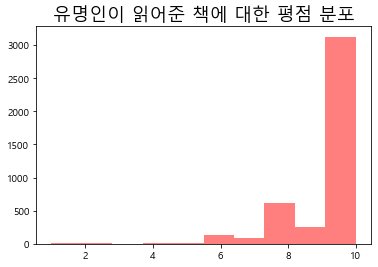

In [110]:
plt.hist(all_review.query('read_by == "celeb"')['rating'], alpha = 0.5, color = "r")
plt.title("유명인이 읽어준 책에 대한 평점 분포", fontsize=18)

Text(0.5, 1.0, '작가가 읽어준 책에 대한 평점 분포')

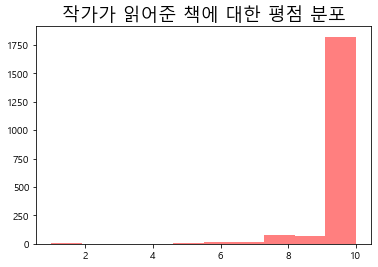

In [111]:
plt.hist(all_review.query('read_by == "author"')['rating'], alpha = 0.5, color = "r")
plt.title("작가가 읽어준 책에 대한 평점 분포", fontsize=18)

Text(0.5, 1.0, '비연예인/비작가/비기계가 읽어준 책에 대한 평점 분포')

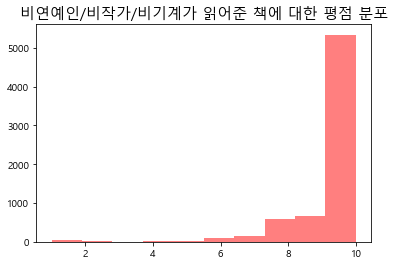

In [112]:
plt.hist(all_review.query('read_by == "someone"')['rating'], alpha = 0.5, color = "r")
plt.title("비연예인/비작가/비기계가 읽어준 책에 대한 평점 분포", fontsize=15)

Text(0.5, 1.0, '기계가 읽어준 책에 대한 평점 분포')

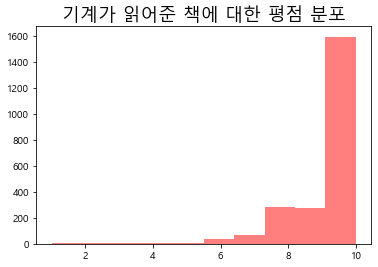

In [113]:
plt.hist(all_review.query('read_by == "robot"')['rating'], alpha = 0.5, color = "r")
plt.title("기계가 읽어준 책에 대한 평점 분포", fontsize=18)

(array([   9.,    6.,    5.,    5.,    9.,   39.,   66.,  279.,  274.,
        1591.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

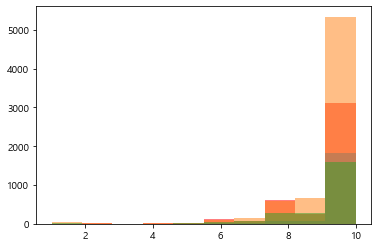

In [114]:
# 따로 그리고 싶다.. 그러나 한 셀 안에..
plt.hist(all_review.query('read_by == "celeb"')['rating'], alpha = 0.5, color = "r")
plt.hist(all_review.query('read_by == "author"')['rating'], alpha = 0.5)
plt.hist(all_review.query('read_by == "someone"')['rating'], alpha = 0.5)
plt.hist(all_review.query('read_by == "robot"')['rating'], alpha = 0.5)

### 비중으로 그림

In [115]:
review_count_read_by[['author_%']].iloc[:9].values.sum()

9.100000000000001

In [116]:
review_count_read_by[['author_%']].iloc[9].values.sum()

90.7

In [117]:
review_count_read_by.sample()

read_by,author,celeb,robot,someone,author_%,celeb_%,robot_%,someone_%
rating,,,,,,,,
7.0,17.0,83.0,66.0,149.0,0.8,2.0,2.9,2.1


In [118]:
author_rest = review_count_read_by[['author_%']].iloc[:9].values.sum()
author_10 = review_count_read_by[['author_%']].iloc[9].values.sum()
celeb_rest = review_count_read_by[['celeb_%']].iloc[:9].values.sum()
celeb_10 = review_count_read_by[['celeb_%']].iloc[9].values.sum()
robot_rest = review_count_read_by[['robot_%']].iloc[:9].values.sum()
robot_10 = review_count_read_by[['robot_%']].iloc[9].values.sum()
someone_rest = review_count_read_by[['someone_%']].iloc[:9].values.sum()
someone_10 = review_count_read_by[['someone_%']].iloc[9].values.sum()

review_voice_10_and_rest = pd.DataFrame({"author" : [author_rest, author_10], 
              "celeb" : [celeb_rest, celeb_10], 
              "robot" : [robot_rest, robot_10], 
              "someone" : [someone_rest, someone_10]
             }, index = ["rating1to9", "rating10"])

review_voice_10_and_rest

,author,celeb,robot,someone
rating1to9,9.1,26.8,30.3,23.3
rating10,90.7,73.1,69.7,76.6


In [239]:
plt.title?

Text(0.5, 1.0, '작가가 읽어준 책의 평점')

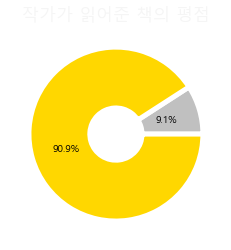

In [119]:
plt.pie(review_voice_10_and_rest['author'], 
        # labels = ["1 to 9","10"], 
        autopct='%.1f%%',
        colors = ["silver","gold"],
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})

plt.title("작가가 읽어준 책의 평점", fontdict = {'color': 'whitesmoke', 'size': 17})

Text(0.5, 1.0, '연예인이 읽어준 책의 평점')

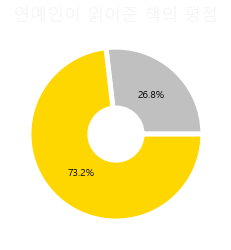

In [120]:
plt.pie(review_voice_10_and_rest['celeb'], 
        #labels = ["1_to_9","10"], 
        autopct='%.1f%%',
        colors = ["silver","gold"],
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})

plt.title("연예인이 읽어준 책의 평점", fontdict = {'color': 'whitesmoke', 'size': 17})

Text(0.5, 1.0, '기계가 읽어준 책의 평점')

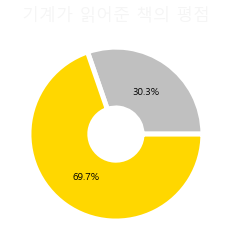

In [121]:
plt.pie(review_voice_10_and_rest['robot'], 
        #labels = ["1_to_9","10"], 
        autopct='%.1f%%',
        colors = ["silver","gold"],
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})

plt.title("기계가 읽어준 책의 평점", fontdict = {'color': 'whitesmoke', 'size': 17})

Text(0.5, 1.0, '비연예인/비작가/비기계가 읽어준 책의 평점')

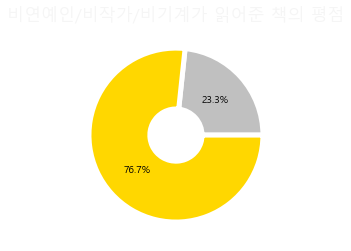

In [122]:
plt.pie(review_voice_10_and_rest['someone'], 
        #labels = ["1_to_9","10"], 
        autopct='%.1f%%',
        colors = ["silver","gold"],
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})

plt.title("비연예인/비작가/비기계가 읽어준 책의 평점", fontdict = {'color': 'whitesmoke', 'size': 17})

In [123]:
review_voice_rest_ratio = review_count_read_by.loc[:9][['author','celeb','robot','someone']]

review_voice_rest_ratio['author_%'] = round(review_voice_rest_ratio['author'] / review_voice_rest_ratio['author'].sum(),3)*100

review_voice_rest_ratio['celeb_%'] = round(review_voice_rest_ratio['celeb'] / review_voice_rest_ratio['celeb'].sum(),3)*100

review_voice_rest_ratio['robot_%'] = round(review_voice_rest_ratio['robot'] / review_voice_rest_ratio['robot'].sum(),3)*100

review_voice_rest_ratio['someone_%'] = round(review_voice_rest_ratio['someone'] / review_voice_rest_ratio['someone'].sum(), 3)*100

In [124]:
review_voice_rest_ratio

read_by,author,celeb,robot,someone,author_%,celeb_%,robot_%,someone_%
rating,,,,,,,,
1.0,5.0,5.0,9.0,44.0,2.7,0.4,1.3,2.7
2.0,2.0,17.0,6.0,12.0,1.1,1.5,0.9,0.7
3.0,0.0,2.0,5.0,7.0,0.0,0.2,0.7,0.4
4.0,2.0,16.0,5.0,15.0,1.1,1.4,0.7,0.9
5.0,7.0,10.0,9.0,27.0,3.8,0.9,1.3,1.7
6.0,12.0,131.0,39.0,109.0,6.5,11.5,5.6,6.7
7.0,17.0,83.0,66.0,149.0,9.1,7.3,9.6,9.2
8.0,74.0,615.0,278.0,586.0,39.8,54.0,40.2,36.0
9.0,67.0,260.0,274.0,678.0,36.0,22.8,39.7,41.7


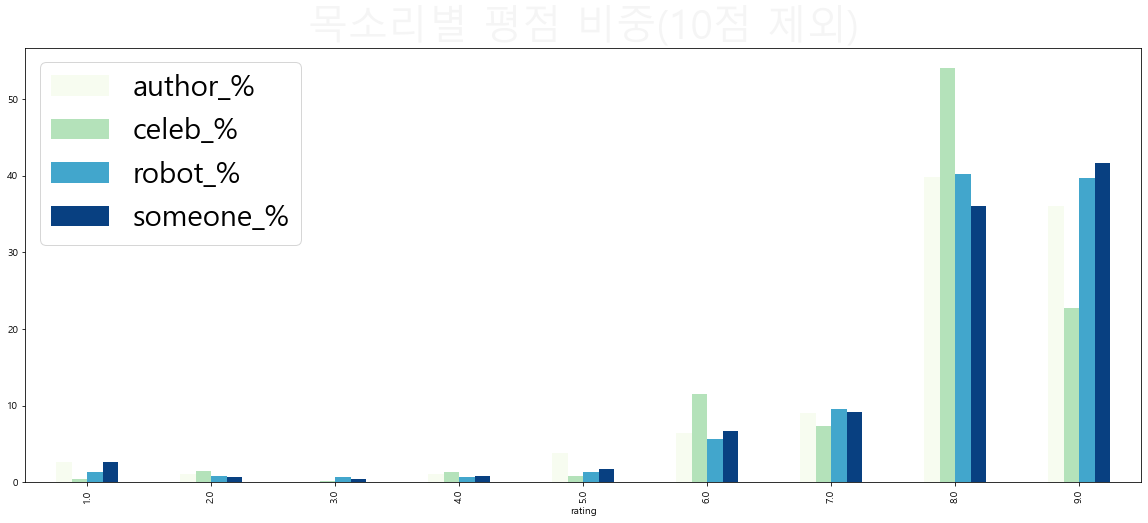

In [125]:
px = review_voice_rest_ratio[['author_%','celeb_%','robot_%','someone_%']].plot(
    kind='bar', colormap = 'GnBu', figsize = (20,8))

px.set_title("목소리별 평점 비중(10점 제외)", fontsize = 40, color = 'whitesmoke')
px.legend(fontsize = 29 ,loc = 'upper left')

### 목소리별 평점 회귀분석

In [126]:
from statsmodels.formula.api import ols

In [127]:
ols('rating ~ read_by', data = all_review).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     61.62
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           1.35e-39
Time:                        12:51:52   Log-Likelihood:                -24581.
No. Observations:               15530   AIC:                         4.917e+04
Df Residuals:                   15526   BIC:                         4.920e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.7897      0.026    372.237      0.000       9.738       9.841
read_by[T.celeb]      -0.4038      0.032    -12.666      0.000      -0.466      -0.341
read_by[T.robot]      -0.4139      0.036    -11.481      0.000      -0.485      -0.343
read_by[T.someone]    -0.2920      0.030     -9.781      0.000      -0.350      -0.233
==============================================================================
Omnibus:                    11532.161   Durbin-Watson:                   1.653
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           207387.950
Skew:                          -3.485   Prob(JB):                         0.00
Kurtosis:                      19.490   Cond. No.                         6.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

일반적으로 작가가 읽었을 때 가장 평점이 높음<br>
근데 r제곱이 1퍼센트..^^

## 전체 평점 분포

위의 회귀분석 결과에 따르면 읽어주는 목소리에 따른 점수 차이는 최대 0.4점<br>
그러나 우리 데이터의 분포를 생각할 때 0.4점 차이도 크다고 할 수 있음

In [666]:
all_review.groupby('rating')['title'].count().to_frame()

,title
rating,
1.0,63
2.0,37
3.0,14
4.0,39
5.0,53
6.0,291
7.0,315
8.0,1561
9.0,1279


In [128]:
for_plot = all_review['rating'].quantile(np.arange(0, 1, 0.025)).to_frame().reset_index()

for_plot.columns = ['percentage', 'rating_value']

for_plot['percentage'] = for_plot['percentage'].apply(lambda x : round(x, 3)).apply(str)

Text(0.5, 1.0, '평점 분포 (1/4분위까지)')

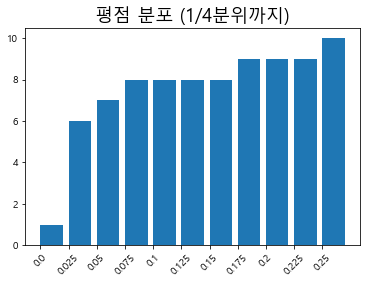

In [129]:
plt.bar(for_plot.iloc[:11, :]['percentage'], for_plot.iloc[:11, :]['rating_value'], align = 'edge')
plt.xticks(rotation = 45)
plt.title("평점 분포 (1/4분위까지)", fontsize = 18)

Text(0.5, 1.0, '평점 분포 (전체)')

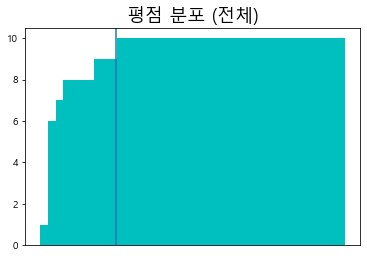

In [130]:
plt.bar(for_plot['percentage'], for_plot['rating_value'], align = 'edge',color = "c", width = 1)
plt.axvline(x=9.9)
plt.xticks([])
plt.title("평점 분포 (전체)", fontsize = 18)

## 리뷰 길이

In [131]:
pb_with_review = all_review.dropna(how = 'any',subset=["review"], axis = 0) #rating만 있는 경우 drop
pb_with_review["length"] = pb_with_review['review'].apply(len)
pb_with_review = pb_with_review.sample(600)
pb_with_review.sample()

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,nickname,rating,title,voice,author,review,created,publish,genre,read_by,length
3322,떵웅이,10.0,[하성운 낭독] 라면은 멋있다 (단편),하성운,공선옥,으아 드디어 ㅜㅜ 매일 밤마다 들을래요,2019.07.04,창비,소설문학,celeb,21


In [132]:
millie = pd.read_csv('data/millie_review.csv', encoding='utf-8')
ml_with_review = millie.dropna(how = 'any',subset=["review"], axis = 0) #rating만 있는 경우 drop
ml_with_review["length"] = ml_with_review['review'].apply(len)
ml_with_review = ml_with_review.sample(600)
ml_with_review.sample()

,Unnamed: 0,nickname,created,review,length
613,613,샤방김,2020.11.10,오정세님 때문에 처음 들어본 오디오북인데 어린아이들이 듣기에도 너무 좋을법한 목소리예요,48


In [133]:
welaa = pd.read_csv('data/welaa_review.csv', encoding='utf-8')
wl_with_review = welaa.dropna(how = 'any',subset=["review"], axis = 0) #rating만 있는 경우 drop
wl_with_review["length"] = wl_with_review['review'].apply(len)
wl_with_review = wl_with_review.sample(600)
wl_with_review.sample()

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,nickname,created,review,length
1051,1051,김동오,2020.11.23 15:51,좋은 교양 입문서. \n얘기하기 쉽게 가볍게 가볍게,27


In [134]:
naver = pd.read_csv('data/naver_imsi_review.csv', encoding='utf-8')
nv_with_review = naver.dropna(how = 'any',subset=["review"], axis = 0) #rating만 있는 경우 drop
nv_with_review["length"] = nv_with_review['review'].apply(len)
nv_with_review = nv_with_review.sample(600)
nv_with_review.sample()

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,nickname,created,review,title,author,voice,length
724,3,홍서리,2020-09-05 04:04,ㅋㅋㅋㅋㅋ 초반 부분 듣는데 이게 뭐야ㅋㅋㅋ 개그물인가,에소릴의 드래곤,이영도,박상훈 신범식 선우현수 신온유 정주원 이아름,30


### 히스토그램

In [ ]:
# patches[0].set_facecolor('gray')

# for i in range(1, len(patches)):
#      patches[i].set_facecolor('c')
# for i in range(0,1):
#     patches[i].set_facecolor('c')
# for i in range(1, len(patches)):
#     patches[i].set_facecolor('gray')

오디오클립: 22C463
윌라: A57E4F
하늘 : #54CAEA


In [590]:
plt.legend?

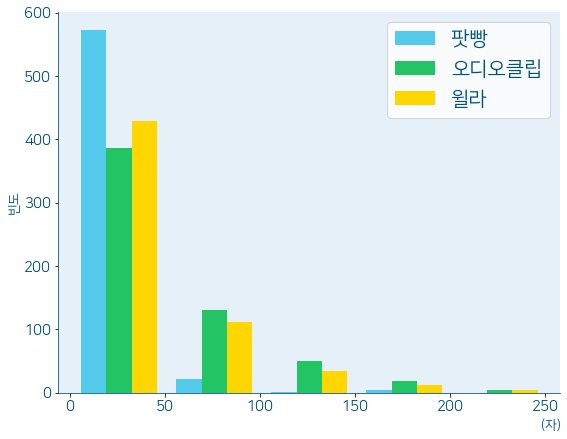

In [600]:
# Make a separate list for each airline
x1 = pb_with_review['length']
x2 = nv_with_review['length']
x3 = wl_with_review['length']


# Assign colors for each airline and the names
colors = ['#54CAEA', '#22C463', 'gold']
names = ['팟빵', '오디오클립', '윌라']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names

plt.figure(figsize = (9,7))
plt.hist([x1, x2, x3], bins = range(1,300, 50), 
         color = colors, label=names)

# Plot formatting
l = plt.legend(fontsize = 20)
for text in l.get_texts():
    text.set_color('#00517C')

plt.gca().set_facecolor('#E6F0F8')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.yticks(ticks= [])
plt.gca().spines['bottom'].set_color('#00517C')
plt.gca().spines['left'].set_color('#00517C')
plt.xticks(color='#00517C', fontsize =15)
plt.yticks(color='#00517C', fontsize =15)

plt.xlabel('(자)', loc = 'right', size =13, color = '#00517C')
plt.ylabel('빈도', size =13, color = '#00517C')

# plt.title('플랫폼별 댓글 길이 히스토그램', color = "#00517C", size = 30)
plt.show()


In [565]:
from functools import partial

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

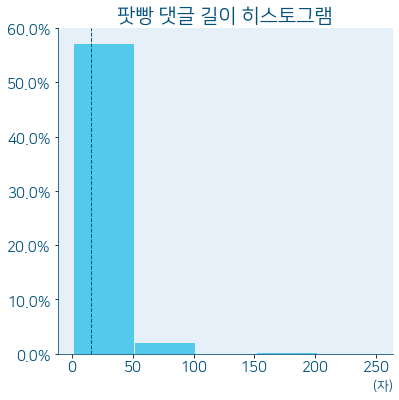

In [577]:
def to_percent(y, position, n):
    s = str(round(100 * y / n, 3))

    if matplotlib.rcParams['text.usetex']:
        return s + r'$\%$'

    return s + '%'


f, ax = plt.subplots(figsize=(6, 6))
ax.hist(pb_with_review['length']
        # , linewidth=1
        , color = '#54CAEA'
        , ec = '#E6F0F8'
        ,bins=range(1,300, 50))
    

percent_formatter = partial(to_percent,
                            n=len(data))
formatter = FuncFormatter(percent_formatter)
plt.gca().yaxis.set_major_formatter(formatter)


plt.axvline(pb_with_review['length'].mean(), color='#00517C', linestyle='dashed', linewidth=1)

plt.gca().set_facecolor('#E6F0F8')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.yticks(ticks= [])
plt.gca().spines['bottom'].set_color('#00517C')
plt.gca().spines['left'].set_color('#00517C')
plt.xticks(color='#00517C', fontsize =15)
plt.yticks(color='#00517C', fontsize =15)

plt.xlabel('(자)', loc = 'right', size =13, color = '#00517C')

plt.title('팟빵 댓글 길이 히스토그램', color = "#00517C", size = 20)
plt.show()


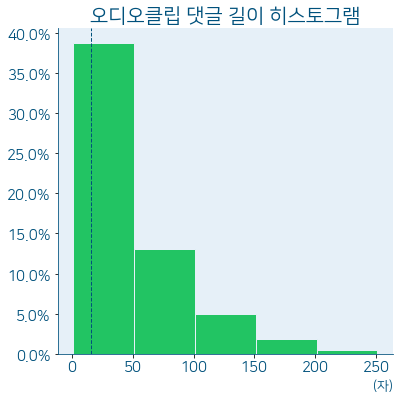

In [578]:
def to_percent(y, position, n):
    s = str(round(100 * y / n, 3))

    if matplotlib.rcParams['text.usetex']:
        return s + r'$\%$'

    return s + '%'


f, ax = plt.subplots(figsize=(6, 6))
ax.hist(nv_with_review['length']
        # , linewidth=1
        , color = '#22C463'
        , ec = '#E6F0F8'
        ,bins=range(1,300, 50))
    

percent_formatter = partial(to_percent,
                            n=len(data))
formatter = FuncFormatter(percent_formatter)
plt.gca().yaxis.set_major_formatter(formatter)


plt.axvline(pb_with_review['length'].mean(), color='#00517C', linestyle='dashed', linewidth=1)

plt.gca().set_facecolor('#E6F0F8')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.yticks(ticks= [])
plt.gca().spines['bottom'].set_color('#00517C')
plt.gca().spines['left'].set_color('#00517C')
plt.xticks(color='#00517C', fontsize =15)
plt.yticks(color='#00517C', fontsize =15)

plt.xlabel('(자)', loc = 'right', size =13, color = '#00517C')

plt.title('오디오클립 댓글 길이 히스토그램', color = "#00517C", size = 20)
plt.show()


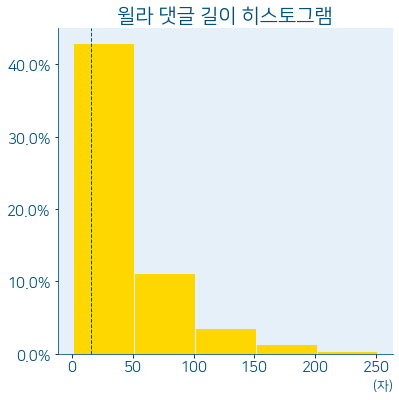

In [579]:
def to_percent(y, position, n):
    s = str(round(100 * y / n, 3))

    if matplotlib.rcParams['text.usetex']:
        return s + r'$\%$'

    return s + '%'


f, ax = plt.subplots(figsize=(6, 6))
ax.hist(wl_with_review['length']
        # , linewidth=1
        , color = 'gold'
        , ec = '#E6F0F8'
        ,bins=range(1,300, 50))
    

percent_formatter = partial(to_percent,
                            n=len(data))
formatter = FuncFormatter(percent_formatter)
plt.gca().yaxis.set_major_formatter(formatter)


plt.axvline(pb_with_review['length'].mean(), color='#00517C', linestyle='dashed', linewidth=1)

plt.gca().set_facecolor('#E6F0F8')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.yticks(ticks= [])
plt.gca().spines['bottom'].set_color('#00517C')
plt.gca().spines['left'].set_color('#00517C')
plt.xticks(color='#00517C', fontsize =15)
plt.yticks(color='#00517C', fontsize =15)

plt.xlabel('(자)', loc = 'right', size =13, color = '#00517C')

plt.title('윌라 댓글 길이 히스토그램', color = "#00517C", size = 20)
plt.show()


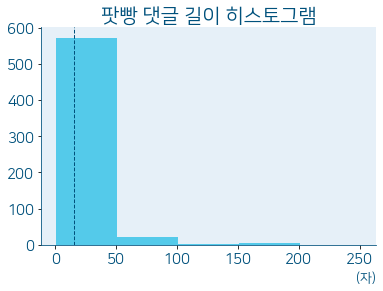

In [543]:
fig, ax = plt.subplots()
data = np.random.rand(1000)

N, bins, patches = ax.hist(pb_with_review['length']
                           #, edgecolor='white'
                           , linewidth=1
                           , bins = range(1,300,50)
                           , color = '#54CAEA'
                          )
plt.axvline(pb_with_review['length'].mean(), color='#00517C', linestyle='dashed', linewidth=1)

plt.gca().set_facecolor('#E6F0F8')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.yticks(ticks= [])
plt.gca().spines['bottom'].set_color('#00517C')
plt.gca().spines['left'].set_color('#00517C')
plt.xticks(color='#00517C', fontsize =15)
plt.yticks(color='#00517C', fontsize =15)

plt.xlabel('(자)', loc = 'right', size =13, color = '#00517C')

plt.title('팟빵 댓글 길이 히스토그램', color = "#00517C", size = 20)
plt.show()

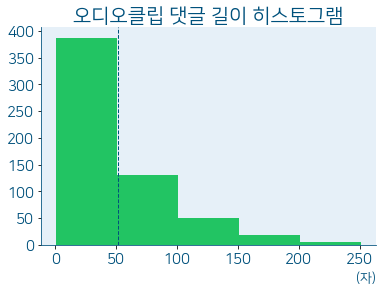

In [544]:
fig, ax = plt.subplots()
data = np.random.rand(1000)

N, bins, patches = ax.hist(nv_with_review['length']
                           #, edgecolor='white'
                           , linewidth=1
                           , bins = range(1,300,50)
                           , color = '#22C463'
                          )
plt.axvline(nv_with_review['length'].mean(), color='#00517C', linestyle='dashed', linewidth=1)

plt.gca().set_facecolor('#E6F0F8')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.yticks(ticks= [])
plt.gca().spines['bottom'].set_color('#00517C')
plt.gca().spines['left'].set_color('#00517C')
plt.xticks(color='#00517C', fontsize =15)
plt.yticks(color='#00517C', fontsize =15)

plt.xlabel('(자)', loc = 'right', size =13, color = '#00517C')


plt.title('오디오클립 댓글 길이 히스토그램', color = "#00517C", size = 20)
plt.show()

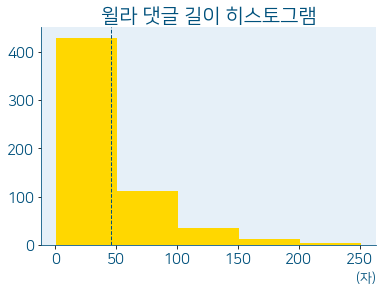

In [545]:
fig, ax = plt.subplots()
data = np.random.rand(1000)

N, bins, patches = ax.hist(wl_with_review['length']
                           #, edgecolor='white'
                           , linewidth=1
                           , bins = range(1,300,50)
                           , color = 'gold'
                          )
plt.axvline(wl_with_review['length'].mean(), color='#00517C', linestyle='dashed', linewidth=1)

plt.gca().set_facecolor('#E6F0F8')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.yticks(ticks= [])
plt.gca().spines['bottom'].set_color('#00517C')
plt.gca().spines['left'].set_color('#00517C')
plt.xticks(color='#00517C', fontsize =15)
plt.yticks(color='#00517C', fontsize =15)

plt.xlabel('(자)', loc = 'right', size =13, color = '#00517C')

plt.title('윌라 댓글 길이 히스토그램', color = "#00517C", size = 20)
plt.show()

### 비중으로 그리기

Text(0.5, 1.0, '팟빵 댓글 길이')

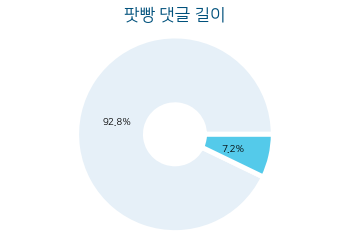

In [355]:
less = len(pb_with_review[pb_with_review['length'] <= 40])
more = len(pb_with_review) - less

plt.pie([less, more], 
        # labels = ["1 to 9","10"], 
        autopct='%.1f%%',
        colors = ["#E6F0F8", "#54CAEA"],
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})

plt.gca().set_facecolor('#E6F0F8')
plt.axis('equal')

plt.title("팟빵 댓글 길이", fontdict = {'color': '#00517C', 'size': 17})

Text(0.5, 1.0, '윌라 댓글 길이')

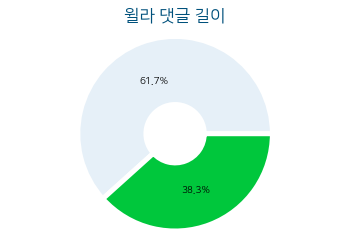

In [372]:
less = len(wl_with_review[wl_with_review['length'] <= 40])
more = len(wl_with_review) - less

plt.pie([less, more], 
        # labels = ["1 to 9","10"], 
        autopct='%.1f%%',
        colors = ["#E6F0F8", "#00C73C"],
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})

plt.gca().set_facecolor('#E6F0F8')
plt.axis('equal')

plt.title("윌라 댓글 길이", fontdict = {'color': '#00517C', 'size': 17})

Text(0.5, 1.0, '오디오클립 댓글 길이')

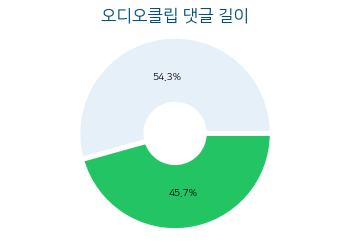

In [373]:
less = len(nv_with_review[nv_with_review['length'] <= 40])
more = len(nv_with_review) - less

plt.pie([less, more], 
        # labels = ["1 to 9","10"], 
        autopct='%.1f%%',
        colors = ["#E6F0F8", "#22C463"],
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})

plt.gca().set_facecolor('#E6F0F8')
plt.axis('equal')

plt.title("오디오클립 댓글 길이", fontdict = {'color': '#00517C', 'size': 17})

### 평균 댓글 길이 비교

In [326]:
print(f"팟빵 : {np.mean(pb_with_review['length'])}")
print(f"네이버 : {np.mean(nv_with_review['length'])}")
print(f"윌라 : {np.mean(wl_with_review['length'])}")


팟빵 : 15.596666666666666
네이버 : 51.736666666666665
윌라 : 45.57333333333333


In [607]:
plt.legend?

In [608]:
plt.bar?

([0, 1, 2], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

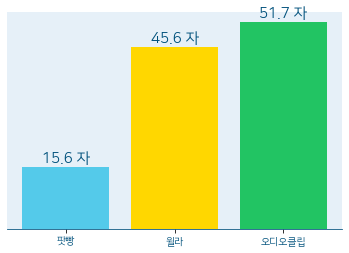

In [613]:
x = plt.bar(x=["팟빵", "윌라", "오디오클립"]
        ,height = [np.mean(pb_with_review['length']), 
                   np.mean(wl_with_review['length']),np.mean(nv_with_review['length'])]
        ,color = ["#54CAEA",  "gold", "#22C463"]
       )

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().set_facecolor('#E6F0F8')
plt.gca().spines['left'].set_color('#00517C')
plt.gca().spines['bottom'].set_color('#00517C')

for p in x.patches:
    left, bottom, width, height = p.get_bbox().bounds
    plt.annotate(f"{round(height,1)} 자",(left+width/2, height+1), ha = 'center', size =15, color = '#00517C')

plt.yticks(ticks= [])
plt.xticks(color= '#00517C')

# plt.title("플랫폼별 댓글 평균 길이", color = '#00517C', size=20)

In [626]:
plt.legend?

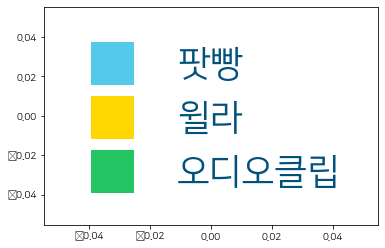

In [631]:
colors = ["#54CAEA", "gold", "#22C463"]



f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(3)]
labels = ['팟빵', "윌라", "오디오클립"]
legend = plt.legend(handles, labels, loc=3, framealpha=1, markerscale = 7,frameon=False,prop={'size': 36}, fontsize = 15)
for text in legend.get_texts():
    text.set_color('#00517C')

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

### 명사/형태소 개수

([0, 1, 2], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

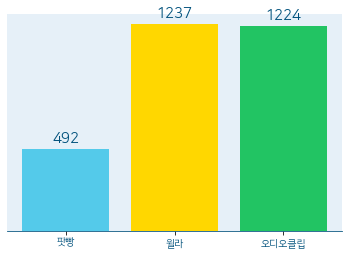

In [476]:
x = plt.bar(x=["팟빵", "윌라", "오디오클립"]
        ,height = [492, 1237, 1224]
        ,color = ["#54CAEA",  "gold", "#22C463"]
       )

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().set_facecolor('#E6F0F8')
plt.gca().spines['left'].set_color('#00517C')
plt.gca().spines['bottom'].set_color('#00517C')

for p in x.patches:
    left, bottom, width, height = p.get_bbox().bounds
    plt.annotate(f"{int(height)}",(left+width/2, height+35), ha = 'center', size =15, color = '#00517C')
    
    
plt.yticks(ticks= [])
plt.xticks(color= '#00517C')

plt.title("플랫폼별 댓글 명사 개수", color = '#00517C', size=20)

([0, 1, 2], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

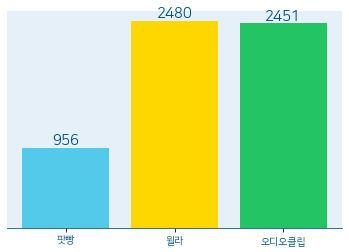

In [481]:
x = plt.bar(x=["팟빵", "윌라", "오디오클립"]
        ,height = [956, 2480, 2451]
        ,color = ["#54CAEA",  "gold", "#22C463"]
       )

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().set_facecolor('#E6F0F8')
plt.gca().spines['left'].set_color('#00517C')
plt.gca().spines['bottom'].set_color('#00517C')

for p in x.patches:
    left, bottom, width, height = p.get_bbox().bounds
    plt.annotate(f"{int(height)}",(left+width/2, height+45), ha = 'center', size =15, color = '#00517C')
    
    
plt.yticks(ticks= [])
plt.xticks(color= '#00517C')

#plt.title("플랫폼별 댓글 형태소 개수", color = '#00517C', size=20)

### 좋아요, 잘들었어요, 감사합니다 

In [676]:
good = ["좋아요", "좋네요", "좋습니다"]
good_len  = len(all_review[all_review['review'].isin(good)])

listen = ["잘들었습니다", "잘 들었습니다", "잘들었어요", "잘 들었어요"]
listen_len = len(all_review[all_review['review'].isin(listen)])

thanks = ["감사합니다", "감사해요", "고맙습니다", "고마워요"]
thanks_len = len(all_review[all_review['review'].isin(thanks)])

print(f"'좋아요' : {good_len}      |  전체 댓글 대비 '좋아요' 비율 : {round(good_len/len(all_review)*100,2)}%")
print(f"'잘들었습니다' : {listen_len} |  전체 댓글 대비 '잘들었습니다' 비율 : {round(listen_len/len(all_review)*100,2)}%")
print(f"'감사합니다' : {thanks_len}   |  전체 댓글 대비 '감사합니다' 비율 : {round(thanks_len/len(all_review)*100,2)}%")

'좋아요' : 1361      |  전체 댓글 대비 '좋아요' 비율 : 8.76%
'잘들었습니다' : 982 |  전체 댓글 대비 '잘들었습니다' 비율 : 6.32%
'감사합니다' : 257   |  전체 댓글 대비 '감사합니다' 비율 : 1.65%


In [646]:
rest_len = len(all_review) - (listen_len + thanks_len + good_len)

Text(0.5, 1.0, '잘들었어요')

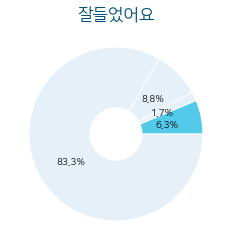

In [658]:
plt.pie([listen_len, thanks_len, good_len, rest_len], 
        # labels = ["1 to 9","10"], 
        autopct='%.1f%%',
        colors = ["#54CAEA","#E6F0F8","#E6F0F8","#E6F0F8"],
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 1})

plt.title("잘들었어요", fontdict = {'color': '#00517C', 'size': 17})

([<matplotlib.patches.Wedge at 0x2850e0770c8>,
 [Text(0.951327256445562, 0.5522467303151373, ''),
  Text(-0.9513272305930258, -0.5522467748499795, '')],
 [Text(0.5189057762430338, 0.30122548926280207, '16.7%'),
  Text(-0.5189057621416504, -0.30122551355453425, '83.3%')])

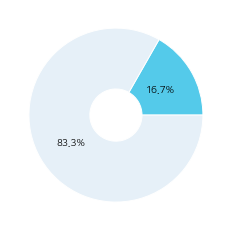

In [663]:
plt.pie([listen_len+thanks_len+good_len, rest_len], 
        # labels = ["1 to 9","10"], 
        autopct='%.1f%%',
        colors = ["#54CAEA", "#E6F0F8"],
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 1})

# plt.title("좋아요잘들었어요감사합니다", fontdict = {'color': '#00517C', 'size': 17})

Text(0.5, 1.0, '좋아요')

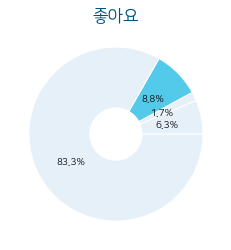

In [657]:
plt.pie([listen_len, thanks_len, good_len, rest_len], 
        # labels = ["1 to 9","10"], 
        autopct='%.1f%%',
        colors = ["#E6F0F8","#E6F0F8","#54CAEA","#E6F0F8"],
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 1})

plt.title("좋아요", fontdict = {'color': '#00517C', 'size': 17})

In [679]:
good = ["좋아요", "좋네요", "좋습니다"]
good_len  = len(welaa[welaa['review'].isin(good)])

listen = ["잘들었습니다", "잘 들었습니다", "잘들었어요", "잘 들었어요"]
listen_len = len(welaa[welaa['review'].isin(listen)])

thanks = ["감사합니다", "감사해요", "고맙습니다", "고마워요"]
thanks_len = len(welaa[welaa['review'].isin(thanks)])

print(f"'좋아요' : {good_len}      |  전체 댓글 대비 '좋아요' 비율 : {round(good_len/len(welaa)*100,2)}%")
print(f"'잘들었습니다' : {listen_len} |  전체 댓글 대비 '잘들었습니다' 비율 : {round(listen_len/len(welaa)*100,2)}%")
print(f"'감사합니다' : {thanks_len}   |  전체 댓글 대비 '감사합니다' 비율 : {round(thanks_len/len(welaa)*100,2)}%")

'좋아요' : 34      |  전체 댓글 대비 '좋아요' 비율 : 0.84%
'잘들었습니다' : 10 |  전체 댓글 대비 '잘들었습니다' 비율 : 0.25%
'감사합니다' : 2   |  전체 댓글 대비 '감사합니다' 비율 : 0.05%


In [680]:
good = ["좋아요", "좋네요", "좋습니다"]
good_len  = len(naver[naver['review'].isin(good)])

listen = ["잘들었습니다", "잘 들었습니다", "잘들었어요", "잘 들었어요"]
listen_len = len(naver[naver['review'].isin(listen)])

thanks = ["감사합니다", "감사해요", "고맙습니다", "고마워요"]
thanks_len = len(naver[naver['review'].isin(thanks)])

print(f"'좋아요' : {good_len}      |  전체 댓글 대비 '좋아요' 비율 : {round(good_len/len(naver)*100,2)}%")
print(f"'잘들었습니다' : {listen_len} |  전체 댓글 대비 '잘들었습니다' 비율 : {round(listen_len/len(naver)*100,2)}%")
print(f"'감사합니다' : {thanks_len}   |  전체 댓글 대비 '감사합니다' 비율 : {round(thanks_len/len(naver)*100,2)}%")

'좋아요' : 5      |  전체 댓글 대비 '좋아요' 비율 : 0.37%
'잘들었습니다' : 6 |  전체 댓글 대비 '잘들었습니다' 비율 : 0.44%
'감사합니다' : 5   |  전체 댓글 대비 '감사합니다' 비율 : 0.37%


In [681]:
네이버 : 1.18
윌라 : 1.14

## 유저별 평점 variance 

In [136]:
review_per_user = all_review.groupby(['nickname', 'title'])['rating'].first().to_frame().reset_index()
review_per_user.sample()

,nickname,title,rating
368,Django,딜리트,9.0


책 한권에 대한 리뷰만 남긴 유저는 제외하고 분산을 살펴보려 함

In [498]:
review_count = review_per_user.groupby('nickname')['rating'].count().to_frame()
review_one = list(review_count.query('rating == 1').index)

In [138]:
review_var = review_per_user[~review_per_user['nickname'].isin(review_one)].groupby('nickname')['rating'].var(ddof = 0).to_frame()
review_var.columns = ['rating_variance']
review_var.sample()

,rating_variance
nickname,
김태훈훈,0.25


In [139]:
review_var[review_var['rating_variance'].isnull()].shape[0]

0

In [140]:
review_var.query('nickname == "amartia"')

,rating_variance
nickname,
amartia,0.25


In [141]:
review_per_user.query('nickname == "amartia"')

,nickname,title,rating
954,amartia,모두 거짓말을 한다,8.0
955,amartia,아몬드,9.0


In [142]:
review_var.sample(3)

,rating_variance
nickname,
wow7165,0.0
peaceminus,0.5
bsy0076,0.0


In [143]:
np.var(review_per_user.query("nickname == 'djsjsjss'")['rating'])

6.6942148760330555

### 유저당 평점 분산 시각화

Text(0.5, 1.0, '유저당 평점 분산')

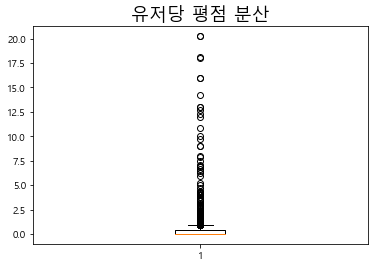

In [144]:
plt.boxplot(review_var)
plt.title("유저당 평점 분산",fontsize=18)

Text(0.5, 1.0, '유저당 평점 분산 (아웃라이어 제외)')

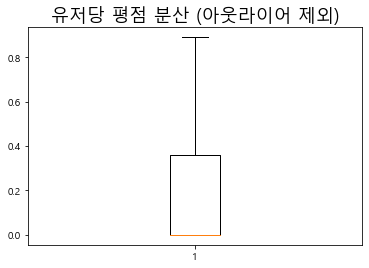

In [145]:
plt.boxplot(review_var, showfliers=False)
plt.title("유저당 평점 분산 (아웃라이어 제외)",fontsize=18)

### heavy user의 평점 분산

In [146]:
review_var_count = review_var.merge(review_count, left_index = True, right_index = True)
review_var_count.columns = ['rating_variance', 'rating_count']
review_var_count.sample()

,rating_variance,rating_count
nickname,,
오중사V2,0.0,11


In [147]:
review_count.describe()

,rating
count,4450.000000
mean,3.489213
std,6.100897
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,65.000000


In [148]:
review_var.quantile(np.arange(0, 1, 0.25))

,rating_variance
0.00,0.000000
0.25,0.000000
0.50,0.000000
0.75,0.359844


In [149]:
review_count.quantile(np.arange(0.75, 1, 0.05))

,rating
0.75,3.0
0.80,4.0
0.85,5.0
0.90,9.0
0.95,16.0


In [150]:
review_count.quantile(np.arange(0.9, 1, 0.025))

,rating
0.900,9.000
0.925,12.000
0.950,16.000
0.975,21.775


Text(0.5, 1.0, 'Heavy User의 유저당 평점 분산 (Flier 포함)')

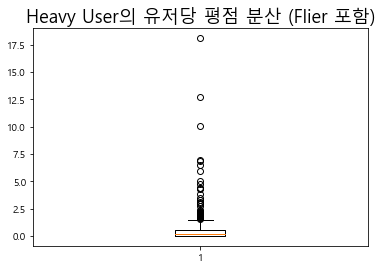

In [151]:
for_plot = review_var_count[review_var_count['rating_count'] >= 12]['rating_variance']
plt.boxplot(for_plot)
plt.title("Heavy User의 유저당 평점 분산 (Flier 포함)",fontsize=18)

Text(0.5, 1.0, 'Heavy User의 유저당 평점 분산 (Flier 제외)')

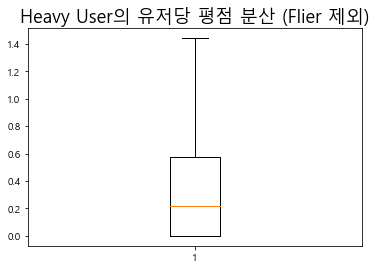

In [152]:
for_plot = review_var_count[review_var_count['rating_count'] >= 12]['rating_variance']
plt.boxplot(for_plot, showfliers=False)
plt.title("Heavy User의 유저당 평점 분산 (Flier 제외)",fontsize=18)

### 별점 분포가 넓은 유저들의 특징

In [153]:
review_var_count['rating_variance'].describe()

count    1646.000000
mean        0.527955
std         1.652693
min         0.000000
25%         0.000000
50%         0.000000
75%         0.359844
max        20.250000
Name: rating_variance, dtype: float64

In [154]:
review_var_count['rating_variance'].quantile(np.arange(0.75, 1, 0.05))

0.75    0.359844
0.80    0.634615
0.85    0.888889
0.90    1.018988
0.95    2.250000
Name: rating_variance, dtype: float64

In [155]:
var_over_2 = list(review_var_count[review_var_count['rating_variance'] >= 2].index)

평점 분산이 2 이상인 user들만 모아서 리스트로 만들었음

In [156]:
review_var_count.loc[var_over_2].rating_count.describe()

count    97.000000
mean     10.855670
std      12.792405
min       2.000000
25%       2.000000
50%       5.000000
75%      13.000000
max      54.000000
Name: rating_count, dtype: float64

Text(0.5, 1.0, '평점 분산이 2 이상의 유저의 평가 횟수')

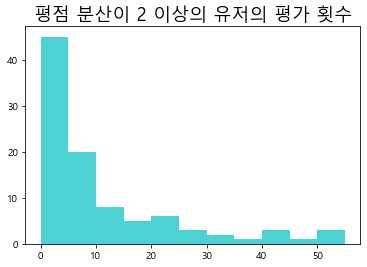

In [157]:
plt.hist(review_var_count.loc[var_over_2].rating_count, bins = np.arange(0,60,5), color = 'c', alpha = 0.7)
plt.title('평점 분산이 2 이상의 유저의 평가 횟수', fontsize=18)

In [158]:
df = all_review[all_review['nickname'].isin(var_over_2)].pivot_table(index='nickname', columns = 'genre', values ='title', aggfunc = 'count')

In [159]:
# df.replace(np.NaN, 0, inplace=True)
df.sample()

genre,경제경영,소설문학,어린이동화,오디오북스,인문교양,자기계발
nickname,,,,,,
이복남,NaN,6.0,NaN,2.0,1.0,2.0


In [160]:
df1 = all_review[all_review['nickname'].isin(var_over_2)][['nickname', 'review']]
df1['review_length'] = df1['review'].apply(str).apply(lambda x :len(x))
df1 = df1.groupby('nickname')['review_length'].mean().to_frame()
df1.sample()

,review_length
nickname,
jinwew,18.0


In [161]:
df1.review_length.describe()

count     97.000000
mean      21.458837
std       27.209600
min        2.000000
25%        6.000000
50%       12.142857
75%       25.333333
max      167.000000
Name: review_length, dtype: float64

In [162]:
df2 = all_review[['nickname', 'review']]
df2['review_length'] = df2['review'].apply(str).apply(lambda x :len(x))
df2 = df2.groupby('nickname')['review_length'].mean().to_frame()
df2.review_length.describe()

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count    4450.000000
mean       19.445836
std        28.392580
min         1.000000
25%         6.000000
50%        11.225000
75%        21.000000
max       590.000000
Name: review_length, dtype: float64

Text(0.5, 1.0, '평점 분산이 2 이상인 유저들의 평균 댓글 길이')

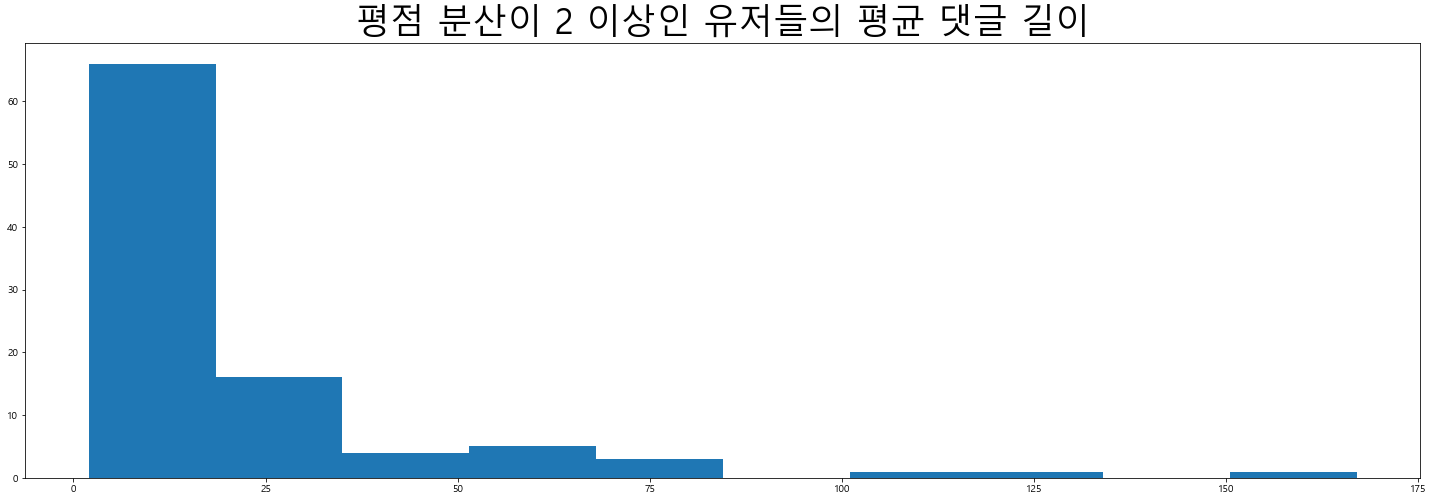

In [163]:
plt.figure(figsize = (25, 8))
plt.hist(df1.review_length)
plt.title("평점 분산이 2 이상인 유저들의 평균 댓글 길이", fontsize = 35)

Text(0.5, 1.0, '모든 유저들의 평균 댓글 길이')

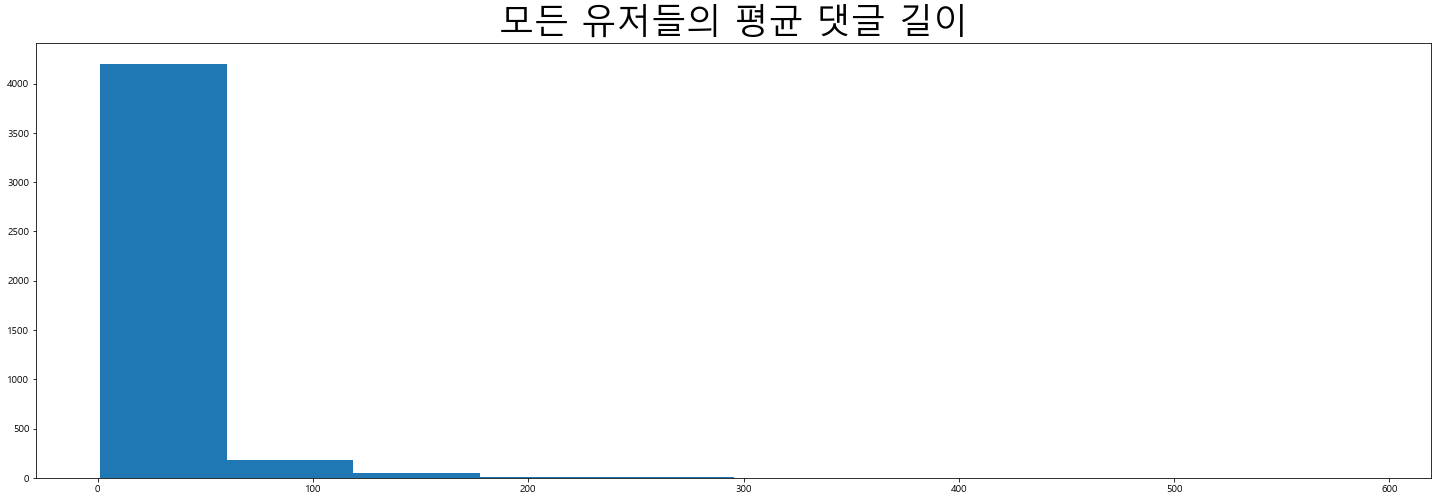

In [164]:
plt.figure(figsize = (25, 8))
plt.hist(df2.review_length)
plt.title("모든 유저들의 평균 댓글 길이", fontsize = 35)

분산이 클 수록 평균 댓글 길이가 길 줄 알았는데 그건 아님

이 이상으론 텍스트분석 필요

### 분산이 0인 유저는 진짜 100점 남발?

In [165]:
user_var_0 = list(review_var.query('rating_variance == 0').index)

In [166]:
review_per_user[review_per_user['nickname'].isin(user_var_0)].rating.unique()

array([10.,  8.,  9.,  2.,  6.,  7.])

In [167]:
len(user_var_0)

880

In [168]:
review_all_10 = len(review_per_user[review_per_user['nickname'].isin(user_var_0)].query('rating == 10')['nickname'].unique())
review_all_9 = len(review_per_user[review_per_user['nickname'].isin(user_var_0)].query('rating == 9')['nickname'].unique())

review_all_8 = len(review_per_user[review_per_user['nickname'].isin(user_var_0)].query('rating == 8')['nickname'].unique())

review_all_7 = len(review_per_user[review_per_user['nickname'].isin(user_var_0)].query('rating == 7')['nickname'].unique())

review_all_2 = len(review_per_user[review_per_user['nickname'].isin(user_var_0)].query('rating == 2')['nickname'].unique())

In [169]:
print(f"전체 유저 중 평점 분산이 0인 유저는 :{len(user_var_0)}명")
print('그중')
print(f"모든 평점이 10점인 유저는 : {review_all_10}명")
print(f"모든 평점이 9점인 유저는  : {review_all_9}명")
print(f"모든 평점이 8점인 유저는  : {review_all_8}명")
print(f"모든 평점이 7점인 유저는  : {review_all_7}명")
print(f"모든 평점이 2점인 유저는  : {review_all_2}명")

전체 유저 중 평점 분산이 0인 유저는 :880명
그중
모든 평점이 10점인 유저는 : 815명
모든 평점이 9점인 유저는  : 19명
모든 평점이 8점인 유저는  : 42명
모든 평점이 7점인 유저는  : 2명
모든 평점이 2점인 유저는  : 1명


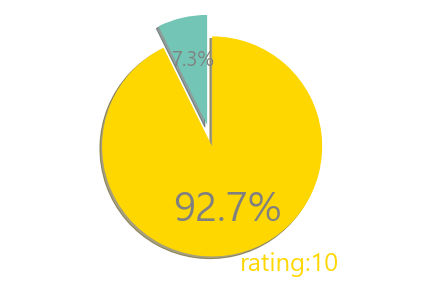

In [170]:
# Pie chart
labels = ['','rating:10']
sizes = [review_all_2+review_all_7+review_all_8+review_all_9, review_all_10]

explode = ( 0, 0.2)  
colors = ['#73C6B6', 'gold']
# '#7FB3D5','#85C1E9','#76D7C4',

fig1, ax1 = plt.subplots()


patches, texts, autotexts = ax1.pie(sizes
                                    ,colors = colors
                                    ,labels=labels
                                    , autopct='%1.1f%%'
                                    , startangle=90
                                    , explode=explode
                                    , shadow=True
                                   # shadow=True, startangle=90, , 
                                   )
for text in texts:
    text.set_color('gold')
    text.set_size(25)

for autotext in autotexts:
    autotext.set_color('grey')
    autotext.set_size(20)
autotext.set_size(40)  
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

## 기간에 따른 비교

### 일별/월별 평점 수 집계 그래프

In [237]:
all_review.sample()

,nickname,rating,title,voice,author,review,created,publish,genre,read_by
6763,delllong,10.0,소년이 온다,NaN,한강,좋네요,2019.04.01,창비,소설문학,robot


In [238]:
rating_dates = all_review.groupby('created')[['rating', 'review']].count().reset_index()
rating_dates.columns = ['date','rating_count', 'review_count']
rating_dates['date'] = rating_dates['date'].apply(str)
rating_dates.tail(3)

,date,rating_count,review_count
421,2020.11.12,5,5
422,2020.11.13,1,1
423,2020.11.21,1,0


Text(0.5, 1.0, '일별 평점 수(2018년 11월 ~ 2020년 11월)')

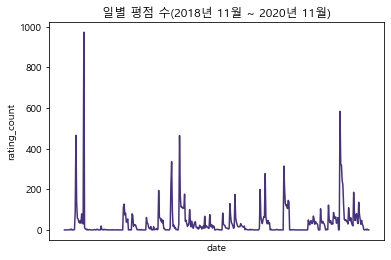

In [173]:
sns.set_palette('viridis')
sns.lineplot(data = rating_dates, x='date', y = 'rating_count')
plt.xticks([])
plt.title('일별 평점 수(2018년 11월 ~ 2020년 11월)')

Text(0.5, 1.0, '일별 댓글 수(2018년 11월 ~ 2020년 11월)')

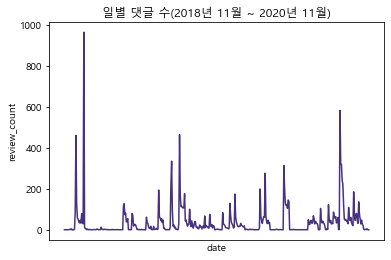

In [174]:
sns.set_palette('viridis')
sns.lineplot(data = rating_dates, x='date', y = 'review_count')
plt.xticks([])
plt.title('일별 댓글 수(2018년 11월 ~ 2020년 11월)')

월별로 묶어보자

In [239]:
rating_dates['month'] = rating_dates['date'].apply(lambda x : x[:-3])

In [240]:
rating_dates.sample()

,date,rating_count,review_count,month
331,2020.07.15,1,1,2020.07


In [241]:
rating_months = rating_dates.groupby('month')[['rating_count', 'review_count']].sum().reset_index()

In [242]:
rating_months.sample()

,month,rating_count,review_count
10,2019.09,905,903


In [248]:
sns.lineplot?

Text(0.5, 1.0, '월별 평점 수(2018년 11월 ~ 2020년 11월)')

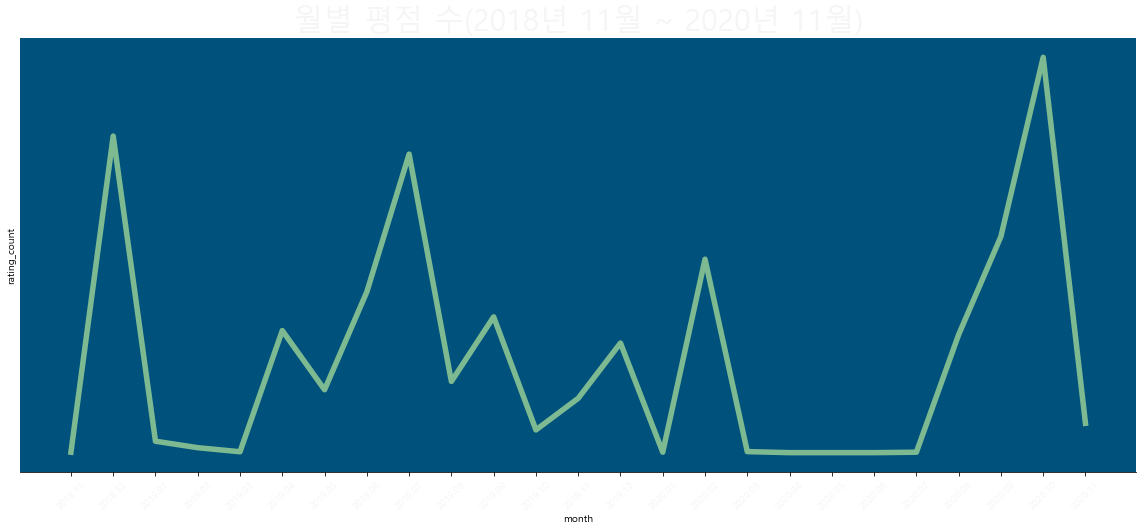

In [253]:
plt.figure(figsize=(20,8))
sns.set_palette('crest')
sns.lineplot(data = rating_months, x='month', y = 'rating_count', linewidth = 5.5)

plt.gca().set_facecolor('#00517C')

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
plt.yticks(ticks= [])
# plt.gca().spines['bottom'].set_color('whitesmoke')
plt.xticks(color='whitesmoke', fontsize =10, rotation = 45)


plt.title('월별 평점 수(2018년 11월 ~ 2020년 11월)', size = 30, color = 'whitesmoke')

Text(0.5, 1.0, '월별 평점 수(2018년 11월 ~ 2020년 11월)')

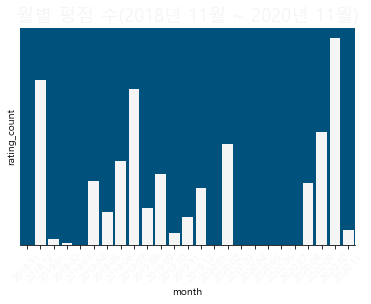

In [260]:
# sns.set_palette('cubehelix')
sns.barplot(data = rating_months, x='month', y = 'rating_count', color = 'whitesmoke')

plt.gca().set_facecolor('#00517C')

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
plt.yticks(ticks= [])
# plt.gca().spines['bottom'].set_color('whitesmoke')
plt.xticks(color='whitesmoke', fontsize =10, rotation = 45)



plt.title('월별 평점 수(2018년 11월 ~ 2020년 11월)', color = 'whitesmoke', size = 18)

Text(0, 0.5, '')

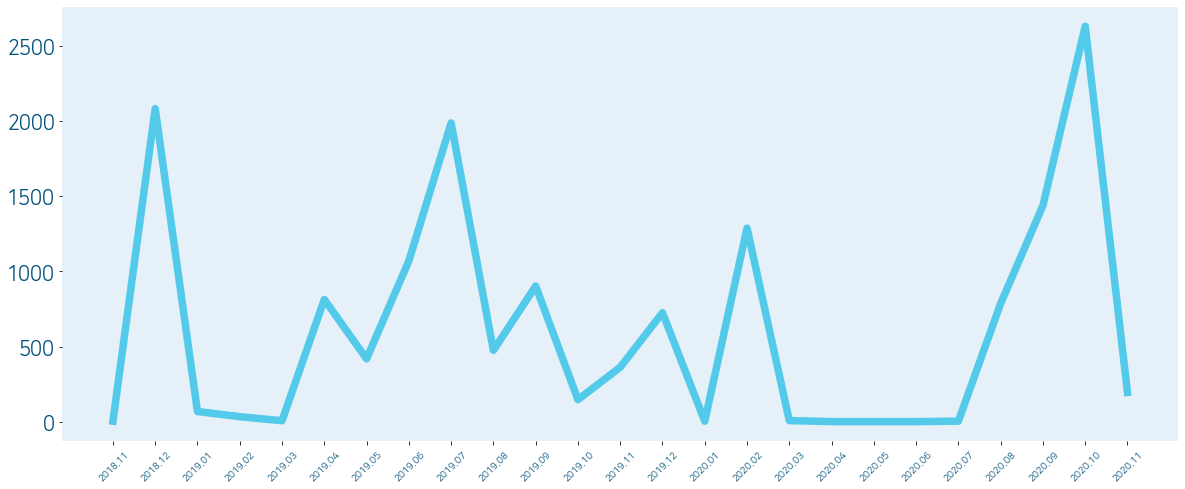

In [601]:
plt.figure(figsize=(20,8))
sns.set_palette('crest')
sns.lineplot(data = rating_months, x='month', y = 'review_count', linewidth = 7.5, color = '#54CAEA')

plt.gca().set_facecolor('#E6F0F8')

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
# plt.yticks(ticks= [])
# plt.gca().spines['bottom'].set_color('whitesmoke')
plt.xticks(color='#00517C', fontsize =10, rotation = 45)
plt.yticks(color='#00517C', fontsize =20)
plt.xlabel('')
plt.ylabel('')

# plt.title('월별 댓글 수(2018년 11월 ~ 2020년 11월)', size = 40, color = '#00517C')

Text(0.5, 1.0, '월별 댓글 수(2018년 11월 ~ 2020년 11월)')

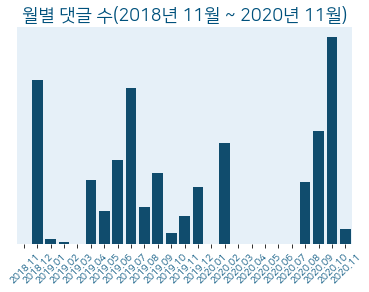

In [321]:
# sns.set_palette('cubehelix')
sns.barplot(data = rating_months, x='month', y = 'review_count', color = '#00517C')

plt.gca().set_facecolor('#E6F0F8')

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.yticks(ticks= [])
# plt.gca().spines['bottom'].set_color('whitesmoke')
plt.xticks(color='#00517C', fontsize =10, rotation = 45)
plt.xlabel('')
plt.ylabel('')

plt.title('월별 댓글 수(2018년 11월 ~ 2020년 11월)', color = '#00517C', size = 18)

In [183]:
rating_months.tail(11)

,month,rating_count,review_count
14,2020.01,6,6
15,2020.02,1288,1288
16,2020.03,10,10
17,2020.04,3,3
18,2020.05,3,3
19,2020.06,3,3
20,2020.07,6,6
21,2020.08,787,787
22,2020.09,1439,1438
23,2020.10,2629,2628


뭐지 코로나 이후에 사용량 폭발했을 것 같은데 오히려 댓글이 줄어들었다...

### 댓글 이벤트와 비교

In [191]:
event = pd.read_csv('data/podbbang_event.csv', index_col = 0)
event = event[event['event_name'].str.contains('오디오북')].reset_index(drop=True)
event.sample()

,event_name,event_period
6,[미스터리 오디오북 퀴즈 이벤트],2020.09.04~2020.09.10


In [185]:
review_event = pd.concat([event[event['event_name'].str.contains('\[')], event.loc[4:9], event.loc[11:]]).reset_index(drop=True)

In [192]:
# review_event['event_book'] = ''
# review_event.to_csv('data/podbban_audio_review_event.csv', encoding = 'cp949')
# review_event.sample()

한 이벤트에 여러 책이 함께 담긴 경우도 있어서 일일이 확인하여 엑셀로 처리함

In [193]:
review_event = pd.read_csv('data/podbban_audio_review_event.csv', encoding = 'cp949')
review_event.sample()

,Unnamed: 0,event_name,event_period,event_book
19,19,데일 카네기 인간관계론 오디오북 이벤트!,2020.08.14~2020.08.20,데일 카네기 인간관계론


In [188]:
# for book in review_event['event_book']:
#     print(book, book in all_book.title.unique())

책 제목이 우리 all_book의 제목과 동일하게 들어갔는지 확인 + 수정함

In [194]:
review_event = pd.read_csv('data/podbban_audio_review_event.csv', encoding = 'cp949', index_col = 0)
for book in review_event['event_book']:
    print(book, book in all_book.title.unique())

살고 싶다는 농담 True
들어본 이야기 True
초등 감정 사용법 True
나는 왠지 대박날 것만 같아! True
당신의 슬픔을 훔칠게요 True
[성진환 낭독] 나조차 나를 사랑하지 못하고 True
일 잘하는 사람은 단순하게 합니다 True
블랙코미디 True
어쩌면 내가 가장 듣고 싶었던 말 (요약) True
두 도시 이야기(요약본) True
위대한 유산(요약본) True
오만과 편견(요약본) True
적과 흑(요약본) True
겨울이야기(요약본) True
순수의 시대(요약본) True
전쟁과 평화(요약본) True
슬리피 할로우의 전설 True
고전 공포 걸작선 True
J. 하버쿡 젭슨의 진술 True
데일 카네기 인간관계론 True
좀머 씨 이야기 True
[강연형] 제국대학의 조센징 True
[EBS 세계문학전집] 걸리버 여행기 True
[EBS 세계문학전집] 장발장 True
[EBS 세계문학전집] 15소년 표류기 True
어른이 되면 괜찮을 줄 알았다 True


In [195]:
review_event['event_start'] =review_event['event_period'].apply(lambda x : x.split("~")[0])
review_event['event_end'] =review_event['event_period'].apply(lambda x : x.split("~")[1])
review_event.sample()

,event_name,event_period,event_book,event_start,event_end
11,세계문학 오디오북 리뷰 이벤트,2020.09.18~2020.09.24,오만과 편견(요약본),2020.09.18,2020.09.24


In [196]:
len(review_event['event_book'].unique())

26

In [197]:
event_start = '2020.09.04'
event_end = '2020.09.10'
'2020.09.03'>= event_start

False

In [389]:
df = all_review.merge(review_event, left_on = 'title', right_on = 'event_book', how = 'inner')
review_during_event = df[(df['created'] >= df['event_start']) & (df['created'] <= df['event_end'])]
review_bef_aft_event = df[~(df['created'] >= df['event_start']) & (df['created'] <= df['event_end'])]

In [491]:
all_review.query('title == "살고 싶다는 농담"').sort_values(by = 'created')

,nickname,rating,title,voice,author,review,created,publish,genre,read_by
944,깨달음,10.0,살고 싶다는 농담,신경선,허지웅,잘들었습니다,2020.10.30,웅진지식하우스,소설문학,someone
843,설원의늑대,8.0,살고 싶다는 농담,신경선,허지웅,잘들었습니다,2020.10.30,웅진지식하우스,소설문학,someone
844,축구adgj1234,10.0,살고 싶다는 농담,신경선,허지웅,감사합니다,2020.10.30,웅진지식하우스,소설문학,someone
845,dunhill2mm,10.0,살고 싶다는 농담,신경선,허지웅,ㅣ,2020.10.30,웅진지식하우스,소설문학,someone
847,누캄프,10.0,살고 싶다는 농담,신경선,허지웅,감사합니다.,2020.10.30,웅진지식하우스,소설문학,someone
...,...,...,...,...,...,...,...,...,...,...
570,zzoozoo,8.0,살고 싶다는 농담,신경선,허지웅,잘들었습니다,2020.11.05,웅진지식하우스,소설문학,someone
571,짱구인생z,10.0,살고 싶다는 농담,신경선,허지웅,잘 들었어요,2020.11.05,웅진지식하우스,소설문학,someone
572,enomi,10.0,살고 싶다는 농담,신경선,허지웅,오 조아여 ㅎㅎ,2020.11.05,웅진지식하우스,소설문학,someone
563,쭌팔,10.0,살고 싶다는 농담,신경선,허지웅,좋아여,2020.11.05,웅진지식하우스,소설문학,someone


In [484]:

review_during_event.query('title == "살고 싶다는 농담"')['review'].count()

392

In [485]:
review_bef_aft_event.query('title == "살고 싶다는 농담"')['review'].count()

0

In [199]:
review_during_event['review'].count()

5794

In [200]:
review_bef_aft_event['review'].count()

59

In [682]:
nv_with_

,nickname,rating,title,voice,author,review,created,publish,genre,read_by
0,유노창민,10.0,저스트 어 모멘트,이나리,이경화,잘들었습니다.,2020.11.06,탐,소설문학,someone
1,나이스가이72,10.0,[단편] 헤엄치는 밤,최인영,한유주,내용 목소리 넘 좋습니다.,2020.10.29,미디어창비,소설문학,someone
2,하브,10.0,[단편] 헤엄치는 밤,최인영,한유주,완전 내용도 장난 아니게 좋네요!! 그리고 목소리도 너무 좋아 집중해서 잘 들을 수...,2020.10.29,미디어창비,소설문학,someone
3,양수,10.0,[단편] 헤엄치는 밤,최인영,한유주,빠져드는 목소리입니다^^,2020.10.29,미디어창비,소설문학,someone
4,티씨지는부산더락,10.0,[단편] 헤엄치는 밤,최인영,한유주,목소리 너무 좋아요,2020.10.28,미디어창비,소설문학,someone
...,...,...,...,...,...,...,...,...,...,...
15525,kay333,10.0,명작동화 영한대역 I,"박미경,손선희",그림 형제,"유명한 그림 형제 동화를 한국어ᆞ영어로 동시에 듣고, 색다른 정보도 알게 되네요. ^^",2019.07.05,왓북,어린이동화,someone
15526,자연에서,10.0,명작동화 영한대역 I,"박미경,손선희",그림 형제,아이 잠자리에서 영한대역으로 틀어주면 좋을거 같아요. 영어 난이도가 쉽진 않지만 자...,2019.07.01,왓북,어린이동화,someone
15527,후후후크,9.0,[단편] 햇볕 동동 구리 동동,NaN,윤기현,애들 재울때 들으려고 샀는데\r\n아빠가 더 재밌네요 옛날 생각도 나고,2020.01.19,창비,어린이동화,robot
15528,소민맘,10.0,마법사 똥맨,NaN,송언,재밌어요,2019.12.19,창비,어린이동화,robot


AttributeError: 'tuple' object has no attribute 'lower'

<Figure size 216x2160 with 0 Axes>

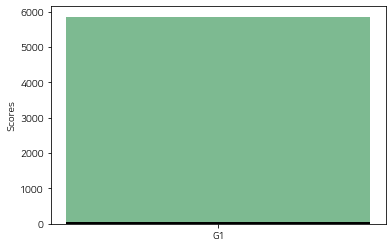

In [445]:
plt.figure(figsize = (3,30))
labels = ['G1']
bef_aft = [59]
during = [5794]


fig, ax = plt.subplots()

ax.bar(labels, bef_aft
       #, yerr=men_std
       , label='이벤트 기간 외', color='black')
ax.bar(labels, during
       , bottom=bef_aft,
       label='이벤트 기간 동안')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender', loc = (0.5, 0,6))
ax.legend()

plt.show()

([0, 1], [Text(0, 0, ''), Text(0, 0, '')])

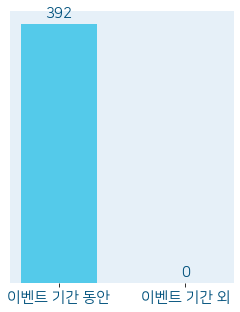

In [495]:
plt.figure(figsize=(4, 5))
x = plt.bar(['이벤트 기간 동안', '이벤트 기간 외']
        , [392, 0]
        , color = ['#54CAEA', '#00517C']
        , width = 0.6)
plt.gca().set_facecolor('#E6F0F8')

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)


for p in x.patches:
    left, bottom, width, height = p.get_bbox().bounds
    plt.annotate(f"{int(height)}",(left+width/2, height+10), ha = 'center', size =15, color = '#00517C')
    
    
plt.yticks(ticks= [])
plt.xticks(color= '#00517C')

# plt.gca().spines['bottom'].set_color('whitesmoke')
plt.xticks(color='#00517C', fontsize =15)
# plt.title('<살고 싶다는 농담> 댓글 수', color = "#00517C", size = 20)

([0, 1], [Text(0, 0, ''), Text(0, 0, '')])

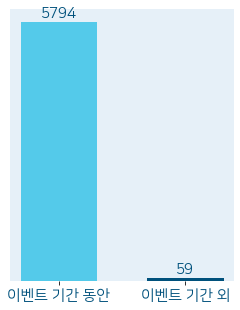

In [469]:
plt.figure(figsize=(4, 5))
x = plt.bar(['이벤트 기간 동안', '이벤트 기간 외']
        , [review_during_event['review'].count(),review_bef_aft_event['review'].count() ]
        , color = ['#54CAEA', '#00517C']
        , width = 0.6)
plt.gca().set_facecolor('#E6F0F8')

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)


for p in x.patches:
    left, bottom, width, height = p.get_bbox().bounds
    plt.annotate(f"{int(height)}",(left+width/2, height+100), ha = 'center', size =15, color = '#00517C')
    
    
plt.yticks(ticks= [])
plt.xticks(color= '#00517C')

# plt.gca().spines['bottom'].set_color('whitesmoke')
plt.xticks(color='#00517C', fontsize =15)

In [392]:
all_review.sample()

,nickname,rating,title,voice,author,review,created,publish,genre,read_by
4478,큐트보이,10.0,더블 side A,남도형,박민규,기대 됩니다 잘 듣겠습니다~,2019.06.22,창비,소설문학,someone


In [393]:
review_during_event.sample()

,nickname,rating,title,voice,author,review,created,publish,genre,read_by,event_name,event_period,event_book,event_start,event_end
5108,김대물,10.0,[EBS 세계문학전집] 장발장,정형석,빅토르 위고,최고에요~~~~,2020.02.23,한국교육방송공사,어린이동화,someone,EBS 세계문학전집을 오디오북으로 만나보세요.,2020.02.19~2020.02.26,[EBS 세계문학전집] 장발장,2020.02.19,2020.02.26


In [395]:
review_event.sample()

,event_name,event_period,event_book,event_start,event_end
6,추석맞이 오디오북 이벤트~!,2020.09.30~2020.10.04,일 잘하는 사람은 단순하게 합니다,2020.09.30,2020.10.04


## general EDA

In [531]:
all_review.shape

(15530, 10)

In [330]:
print(f"리뷰데이터의 크기는             : {all_review.shape}")
print(f"리뷰데이터에 포함된 유저의 수는 : {len(all_review['nickname'].unique())} 명")
print(f"리뷰데이터에 포함된 책의 수는   : {len(all_review['title'].unique())} 권")

리뷰데이터의 크기는             : (15533, 11)
리뷰데이터에 포함된 유저의 수는 : 4450 명
리뷰데이터에 포함된 책의 수는   : 195 권


In [122]:
sns.countplot?

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

FixedFormatter should only be used together with FixedLocator



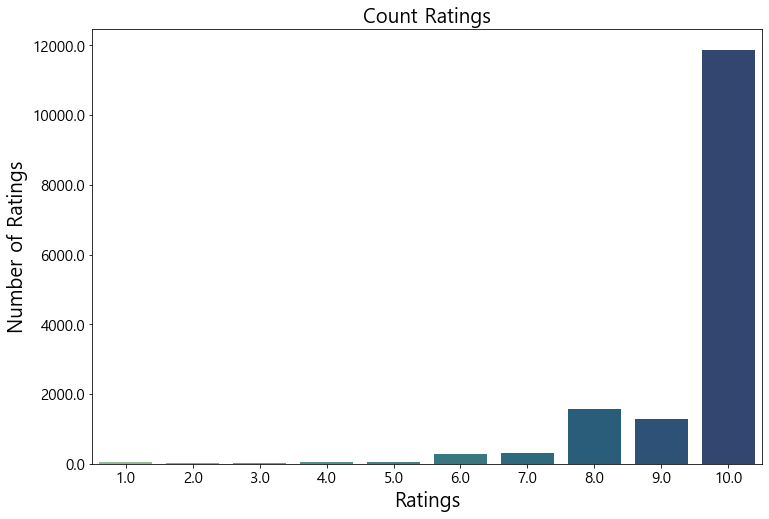

In [127]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=all_review, palette = 'crest')
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count Ratings", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

일단 가장 높은 n개의 값만 보여주는 함수를 만듭니다.

In [336]:
def return_best_n(statistics, n):
    # statistics: array of size review.shape[1] containing one statistic calculated from the dataset
    # n: number of indices to be returned
    # returns: array of size *n* containing the indices of the best scored statistics
    statistics = pd.DataFrame({'statistic':statistics})
    return statistics.sort_values('statistic', ascending = False).iloc[:n]

### Mean Rating <a class="anchor" id="bullet2.1"></a>


In [337]:
means = all_review.pivot_table(columns='title', index = 'nickname', values = 'rating').iloc[:,2:].apply(np.mean)
return_best_n(means,10)

,statistic
title,
"달려라, 아비",100.0
[와우 낭독] 지금 아니면 못 할 일 (단편),100.0
이원승이 읽는 현진건의 운수 좋은 날,100.0
김의성이 읽는 최인호의 타인의 방,100.0
김용 대하역사무협 신조협려 하이라이트,100.0
김영민이 읽는 현경준의 탁류,100.0
길해연이 읽는 양귀자의 원미동 시인,100.0
기주봉이 읽는 하근찬의 수난이대,100.0
공룡 이야기 마을_고집 센 벨로키랍토르(영어),100.0


### Rating Count<a class="anchor" id="bullet2.2"></a>


In [223]:
count = all_review.pivot_table(columns='title', index = 'nickname', values = 'rating').iloc[:,2:].apply(lambda col : np.sum(~np.isnan(col)))

# return_best_n(count,10).index 를 구하면 제목만 뽑을 수 있음
return_best_n(count,10)

NameError: name 'return_best_n' is not defined

In [222]:
count

NameError: name 'count' is not defined

평균 평점 top10의 책은 몇개의 리뷰가 있을까?

In [339]:
top10_avg_ratings = return_best_n(means,10).index
count.loc[top10_avg_ratings]

title
달려라, 아비                      1
[와우 낭독] 지금 아니면 못 할 일 (단편)    1
이원승이 읽는 현진건의 운수 좋은 날         2
김의성이 읽는 최인호의 타인의 방           5
김용 대하역사무협 신조협려 하이라이트         2
김영민이 읽는 현경준의 탁류              1
길해연이 읽는 양귀자의 원미동 시인          1
기주봉이 읽는 하근찬의 수난이대            1
공룡 이야기 마을_고집 센 벨로키랍토르(영어)    1
강신일이 읽는 최서해의 탈출기             1
dtype: int64

### Percentage of Good Ratings<a class="anchor" id="bullet2.3"></a>


In [340]:
good_count = all_review.pivot_table(columns='title', index = 'nickname', values = 'rating').iloc[:,2:].apply(lambda col : np.sum(col >=  80)/np.sum(~np.isnan(col)))
return_best_n(good_count,3)

,statistic
title,
<테이크아웃 오디오북> 목견,1.0
눈물을 자르는 눈꺼풀처럼(시 10편),1.0
신경 끄기의 기술 (완독),1.0


In [13]:
#위 코드 이해하기
col = pivot_df.iloc[:,2:]['나는 왠지 대박날 것만 같아!']
print(np.sum(col >= 80))
print(np.sum(~np.isnan(col)))

387
391


애초에 리뷰가 한개인 경우는 리뷰 수 대비 좋은 리뷰 값이 1로 나옴<br>
이걸 해결하기 위해서 리뷰 숫자가 충분한 경우만 확인

In [341]:
means = pd.DataFrame(means, columns = ['rating_avg'])
count = pd.DataFrame(count, columns = ['no_of_ratings'])
rating_pct = pd.DataFrame(good_count, columns = ['over_80_ratio'])

ratings = pd.merge(left=means, right=count, how='left',left_index=True,right_index=True)

ratings = ratings.merge(rating_pct, how='left',left_index=True,right_index=True)

ratings.sample(3)

,rating_avg,no_of_ratings,over_80_ratio
title,,,
[김병관 낭독] 못 먹어도 go! (단편),100.000000,1,1.000000
남편을 죽이는 서른 가지 방법,55.000000,2,0.500000
[세계환상문학선] 아서 새빌 경의 범죄,89.142857,35,0.885714


In [342]:
ratings.query('no_of_ratings > 100').sort_values(by='over_80_ratio', ascending=False).head(3)

,rating_avg,no_of_ratings,over_80_ratio
title,,,
오만과 편견(요약본),99.339623,106,1.000000
열하일기 첫걸음,99.545455,352,0.997159
세계는 왜 싸우는가,99.171975,314,0.996815


<AxesSubplot:>

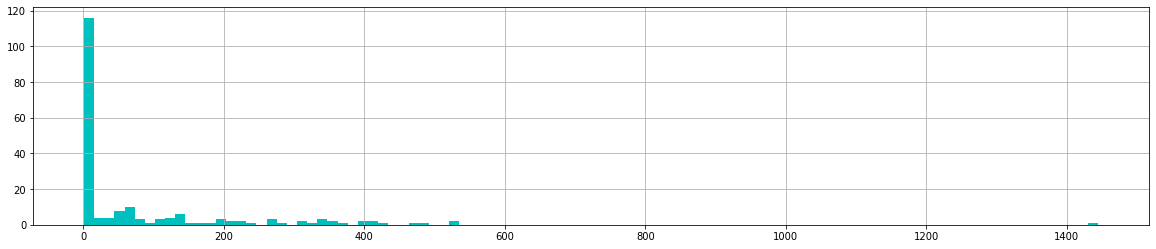

In [343]:
plt.figure(figsize = (20,4))
ratings['no_of_ratings'].hist(bins=100,color='c')

<AxesSubplot:>

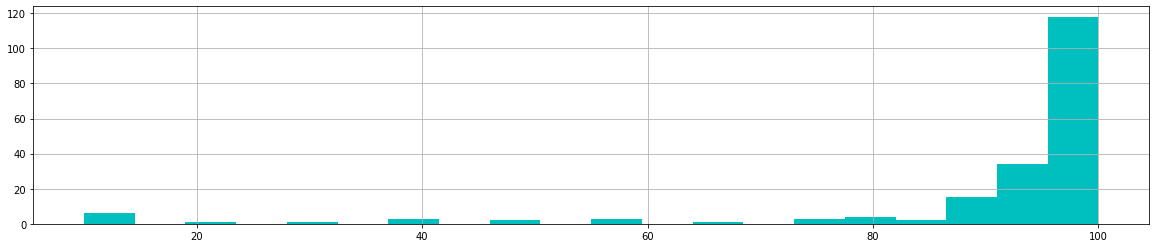

In [344]:
plt.figure(figsize = (20,4))
ratings['rating_avg'].hist(bins=20,color='c')

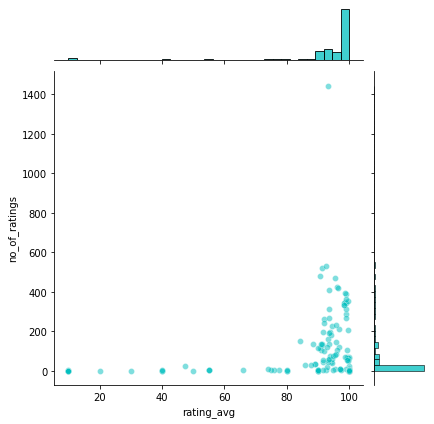

In [345]:
sns.jointplot(x='rating_avg', y='no_of_ratings', data= ratings, alpha = 0.5, color='c')

<div class="alert alert-warning">
분석에서 아래와 같이 rating이 몇개 이상인 책만 뽑아서 봐도 되는것...?
</div>

In [346]:
ratings['no_of_ratings'].describe()

count     193.000000
mean       79.528497
std       157.730190
min         1.000000
25%         1.000000
50%         4.000000
75%        86.000000
max      1445.000000
Name: no_of_ratings, dtype: float64

하위 50%의 분포를 살펴보면: 1~4정도임

In [347]:
ratings['no_of_ratings'].quantile(np.arange(0, 0.5, 0.05))

0.00    1.0
0.05    1.0
0.10    1.0
0.15    1.0
0.20    1.0
0.25    1.0
0.30    1.0
0.35    2.0
0.40    2.0
0.45    2.0
Name: no_of_ratings, dtype: float64

그렇다면 평가를 n개 이하 했던 inactive user 에 대해서도?

In [348]:
count_user_rating = all_review.pivot_table(index='title', columns = 'nickname', values = 'rating').iloc[:,2:].apply(lambda col : np.sum(~np.isnan(col)))

# return_best_n(count,10).index 를 구하면 제목만 뽑을 수 있음
return_best_n(count_user_rating,10)

,statistic
nickname,
마임,65
대룡리말바위,54
고트프리트,52
swagger,51
kwonjkim,47
코끼리311,46
initialj,46
미다진구,46
던힐발란스,45


In [354]:
count_user_rating = pd.DataFrame(count_user_rating)
count_user_rating.columns = ['user_rating_cnt']

In [357]:
count_user_rating['user_rating_cnt'].describe()

count    4448.000000
mean        3.490333
std         6.102040
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        65.000000
Name: user_rating_cnt, dtype: float64

In [356]:
count_user_rating['user_rating_cnt'].quantile(np.arange(0, 0.5, 0.05))

0.00    1.0
0.05    1.0
0.10    1.0
0.15    1.0
0.20    1.0
0.25    1.0
0.30    1.0
0.35    1.0
0.40    1.0
0.45    1.0
Name: user_rating_cnt, dtype: float64

(array([3.934e+03, 2.360e+02, 1.460e+02, 5.700e+01, 2.700e+01, 2.100e+01,
        1.900e+01, 6.000e+00, 1.000e+00, 1.000e+00]),
 array([ 1. ,  7.4, 13.8, 20.2, 26.6, 33. , 39.4, 45.8, 52.2, 58.6, 65. ]),
 <BarContainer object of 10 artists>)

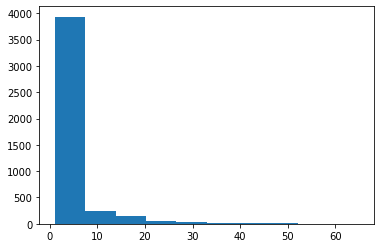

In [358]:
plt.hist(count_user_rating)

{'whiskers': [<matplotlib.lines.Line2D at 0x2be3a174948>,
 'caps': [<matplotlib.lines.Line2D at 0x2be3cc69e88>,
 'boxes': [<matplotlib.lines.Line2D at 0x2be3cc695c8>],
 'medians': [<matplotlib.lines.Line2D at 0x2be3cc79d08>],
 'fliers': [<matplotlib.lines.Line2D at 0x2be3cc79cc8>],
 'means': []}

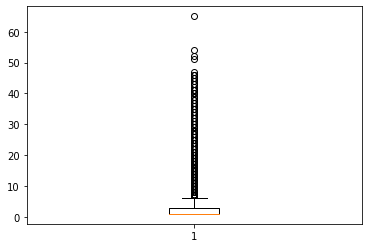

In [361]:
plt.boxplot(data = count_user_rating, x='user_rating_cnt')

In [21]:
ratings_min_6 = ratings.query('no_of_ratings >= 6')
ratings_min_6.head(3)

,rating_avg,no_of_ratings,over_80_ratio
title,,,
[강연형] 제국대학의 조센징,95.441767,498,0.945783
[공포괴담집] 무조건 모르는 척하세요,93.908629,197,0.949239
[공포괴담집] 저승에서 돌아온 남자,94.405286,227,0.964758


<div class="alert alert-warning">
근본적으로 우리가 책이 200권 정도밖에 없는데, <br>
리뷰 5개 이상인 책으로 바꾸면 그게 반토막 나게됨<br>
그렇게 데이터 수를 희생하면서 봐도 되는 것인지..?<br>
</div>

# Prediction With Surprise<a class="anchor" id="bullet3"></a>

## 분석 준비 및 연습

In [497]:
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold
from surprise import SVD
from surprise import NMF
from surprise import KNNBasic
from surprise import KNNBaseline
from surprise.model_selection import cross_validate

In [ ]:
blah 

In [156]:
all_review.sample()

,nickname,rating,title,voice,author,review,created,publish,genre,read_by
7636,우주WOOJOO,10.0,빨강머리 앤 : 에이번리 이야기,이지혜,루시 모드 몽고메리,오디오로 들으니 좋네요,2019.04.29,커뮤니케이션북스,오디오북스,someone


In [157]:
all_review['rating'].unique()

array([10.,  6.,  8.,  9.,  7.,  2.,  3.,  1.,  4.,  5.])

In [159]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(all_review[['nickname', 'title', 'rating']], reader)

In [450]:
# for algo in [SVD(), NMF(), KNNBasic(), KNNBaseline()]:
#     cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

<div class="alert alert-warning">
아래는 cosine similarity로 kNN 구하기<br>
안해도됨
</div>

In [ ]:
# sim_options = {'name': 'cosine',
#                'user_based': False  # compute  similarities between items
#                }
# algo = KNNBasic(sim_options=sim_options)
# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.047612,0.605319,1.642606,0.143283
KNNBasic,1.090485,0.560712,0.990017,2.791874
NMF,3.120457,2.825224,2.614339,0.071487


<div class="alert alert-warning">
아래는 우리만의 알고리즘 만들떄 필요한거<br>
안해도됨
</div>

In [393]:
# from __future__ import (absolute_import, division, print_function,
#                         unicode_literals)
# import numpy as np
# from six import iteritems
# import heapq

# from surprise.prediction_algorithms.predictions import PredictionImpossible
# from surprise.prediction_algorithms.algo_base import AlgoBase

In [316]:
# kf = KFold(n_splits=3)

# algo = NMF() #이걸 SVD, KNNBasic으로 바꿔가며 결과 비교

# for trainset, testset in kf.split(data):
#     # train and test algorithm.
#     algo.fit(trainset)
#     predictions = algo.test(testset)

#     # Compute and print Root Mean Squared Error
#     accuracy.rmse(predictions, verbose=True)

RMSE: 76.8622
RMSE: 76.8241
RMSE: 76.8932


In [632]:
def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [633]:
df

,uid,iid,rui,est,details,Iu,Ui,err
0,youngie,우리 가족은 꽤나 진지합니다,8.0,9.336773,{'was_impossible': False},3,95,1.336773
1,구니양,살고 싶다는 농담,10.0,9.731043,{'was_impossible': False},7,130,0.268957
2,maxsy,최민식이 읽는 이범선의 오발탄,10.0,9.366055,{'was_impossible': False},0,753,0.633945
3,bnb7870,사기를 읽다,10.0,9.434543,{'was_impossible': False},0,113,0.565457
4,미미노리,어쩌면 내가 가장 듣고 싶었던 말 (요약),10.0,9.850028,{'was_impossible': False},2,119,0.149972
...,...,...,...,...,...,...,...,...
3442,헬로우멜로우,살고 싶다는 농담,10.0,9.813733,{'was_impossible': False},0,130,0.186267
3443,고목나무맹이,담배만이 우리 세상,10.0,9.042141,{'was_impossible': False},0,262,0.957859
3444,수원블루사나이,빨강머리 앤 : 초록지붕 집 이야기,8.0,8.656722,{'was_impossible': False},6,174,0.656722
3445,이혼계약,열하일기 첫걸음,10.0,10.000000,{'was_impossible': False},5,144,0.000000


## 분석_POD

In [451]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(all_review[['nickname', 'title', 'rating']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
pod_SVD = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
pod_SVD

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.044225,0.605218,1.754307,0.096075
KNNBasic,1.094358,0.559481,1.157902,3.234350
NMF,3.030852,2.740114,3.140597,0.085107


## 분석_MDL

In [269]:
mydramalist = pd.read_csv('C:/Users/Hanna Kim/Desktop/drama_recommendation/reviews_to_top_40.csv', index_col = 0)

In [161]:
mydramalist.sample()

,title,reviewer,overall,story,acting,music,rewatch
17868,K-POP - The Ultimate Audition,Scroll,6.5,6.0,5.0,8.5,4.0


In [529]:
mydramalist = mydramalist.sample(15533)

In [530]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'overall']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_overall = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_overall

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.537674,1.127358,2.843893,0.211296
KNNBasic,1.824486,1.294432,0.510549,1.182132
NMF,2.692043,2.330032,6.500406,0.203357


In [464]:
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'story']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_story = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_story

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.499345,1.084395,4.176495,0.263630
KNNBasic,1.686498,1.173574,0.298202,1.556503
NMF,2.539696,2.212542,6.430136,0.158907


In [465]:
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'music']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_music = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_music

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.521209,1.114127,4.018252,0.553520
KNNBasic,1.835846,1.292237,0.404250,1.642275
NMF,2.564468,2.215694,7.228006,0.145272


In [466]:
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'acting']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_acting = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_acting

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.258419,0.882337,3.454425,0.428188
KNNBasic,1.409659,0.956341,0.428188,1.830104
NMF,2.789891,2.529618,5.230676,0.175862


In [467]:
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'rewatch']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_rewatch = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_rewatch

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,2.183483,1.633894,2.992994,0.203458
KNNBasic,2.524493,1.816171,0.319479,1.793542


In [163]:
mydramalist[mydramalist.isna().any(axis=1)]

,title,reviewer,overall,story,acting,music,rewatch


In [164]:
mydramalist['mean'] = (mydramalist.iloc[:, 2:]).apply(np.mean, axis=1)

In [165]:
mydramalist.sample()

,title,reviewer,overall,story,acting,music,rewatch,mean
23024,Goong,CarlaSantini,7.0,6.0,8.0,8.0,8.0,7.4


In [166]:
mydramalist['mean'] = (mydramalist.iloc[:, 2:]).apply(np.mean, axis=1)
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'mean']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(),NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_mean = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_mean

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.362973,1.003473,1.866781,0.955305
KNNBasic,1.576465,1.129389,0.182693,0.710768
NMF,2.423697,2.128752,3.015842,0.084497


## 시각화 비교 POD vs. MDL

직관적으로는 팟빵 평점 데이터가 별로일 것 같은데, `

(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

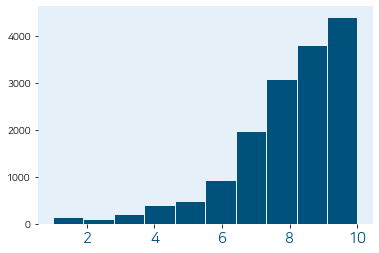

In [636]:
plt.figure(figsize=(6,4))
plt.hist(mydramalist['overall'], bins = 10, color = '#00517C', ec = "#E6F0F8")
plt.gca().set_facecolor('#E6F0F8')


# plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.yticks()
# plt.gca().spines['bottom'].set_color('whitesmoke')
plt.xticks(color='#00517C', fontsize =15)
# plt.title("MyDramaList 평점 히스토그램", size = 20, color = "#00517C", position = (0.5, 1.3))
# ticks= []


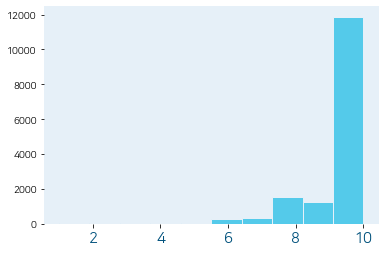

In [637]:
plt.figure(figsize=(6,4))
N, bins, patches = plt.hist(all_review['rating'], bins = 10, color = '#54CAEA', ec = "#E6F0F8")
plt.gca().set_facecolor('#E6F0F8')


patches[9].set_facecolor('#54CAEA')


# plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.yticks() #ticks= []
# plt.gca().spines['bottom'].set_color('whitesmoke')
plt.xticks(color='#00517C', fontsize =15)
# plt.title("팟빵 평점 히스토그램", size = 20, color = "#00517C", position = (0.5, 1.3))

plt.show()

In [559]:
len("한나에오  ")

6

## 개선해볼까

이럴거면 그냥 다 10점 주는 알고리즘 만들자

In [471]:
from surprise import AlgoBase
from surprise import Dataset
from surprise.model_selection import cross_validate


class all_10(AlgoBase):

    def __init__(self):

        # Always call base method before doing anything.
        AlgoBase.__init__(self)

    def estimate(self, u, i):

        return 10

all_10으로 팟빵 예측한 결과는

In [472]:
calc = []
# Perform cross validation
algorithm = all_10()
results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)

# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
calc.append(tmp)
    
pod_all_10 = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
pod_all_10

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
all_10,2.735204,2.098702,0.005983,0.094081


근데 그래도 pod_SVD가 예측 더 잘함...why

팟빵 데이터에도 10점이 아닌게 있으니 다 10점을 때려버리면 안될듯 <br>
그러면 전체 데이터의 평균(global mean)을 사용해서 예측한다면?

In [473]:
class GlobalMean(AlgoBase):

    def __init__(self):

        # Always call base method before doing anything.
        AlgoBase.__init__(self)

    def fit(self, trainset):

        # Here again: call base method before doing anything.
        AlgoBase.fit(self, trainset)

        # Compute the average rating. We might as well use the
        # trainset.global_mean attribute ;)
        self.the_mean = np.mean([r for (_, _, r) in
                                 self.trainset.all_ratings()])

        return self

    def estimate(self, u, i):

        return self.the_mean

In [474]:
data = Dataset.load_from_df(all_review[['nickname', 'title', 'rating']], reader)


calc = []
# Perform cross validation
algorithm = GlobalMean()
results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)

# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
calc.append(tmp)
    
pod_global_mean = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
pod_global_mean

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
GlobalMean,1.185976,0.785805,0.020607,0.072473


In [457]:
mydramalist.sample()

,title,reviewer,overall,story,acting,music,rewatch
3912,49 Days,BAsfaw,7.0,9.0,8.5,6.5,6.5


In [475]:
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'overall']], reader)


calc = []
# Perform cross validation
algorithm = GlobalMean()
results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)

# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
calc.append(tmp)
    
mdl_global_mean = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_global_mean

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
GlobalMean,1.830655,1.400377,0.031582,0.17021


In [476]:
a = pd.DataFrame(np.array([mdl_acting.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['mdl_acting_SVD'])

b = pd.DataFrame(np.array([mdl_story.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['mdl_story_SVD'])

c = pd.DataFrame(np.array([mdl_mean.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['mdl_mean_SVD'])

d = pd.DataFrame(np.array([pod_SVD.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['pod_SVD'])

e = pd.DataFrame(np.array([pod_all_10.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['pod_all_10'])

f = pd.DataFrame(np.array([pod_global_mean.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['pod_global_mean'])

g = pd.DataFrame(np.array([mdl_global_mean.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['mdl_global_mean'])

In [477]:
all_algo = pd.concat([a,b,c,d,e,f,g], axis = 0)
all_algo

,test_rmse,test_mae,fit_time,test_time
mdl_acting_SVD,1.258419,0.882337,3.454425,0.428188
mdl_story_SVD,1.499345,1.084395,4.176495,0.263630
mdl_mean_SVD,1.358417,0.999815,2.775909,0.250330
pod_SVD,1.044225,0.605218,1.754307,0.096075
pod_all_10,2.735204,2.098702,0.005983,0.094081
pod_global_mean,1.185976,0.785805,0.020607,0.072473
mdl_global_mean,1.830655,1.400377,0.031582,0.170210


In [478]:
all_algo.loc[['mdl_global_mean', 'mdl_acting_SVD']]

,test_rmse,test_mae,fit_time,test_time
mdl_global_mean,1.830655,1.400377,0.031582,0.170210
mdl_acting_SVD,1.258419,0.882337,3.454425,0.428188


In [479]:
all_algo.loc[['pod_global_mean', 'pod_SVD']]

,test_rmse,test_mae,fit_time,test_time
pod_global_mean,1.185976,0.785805,0.020607,0.072473
pod_SVD,1.044225,0.605218,1.754307,0.096075


mdl과 다르게 pod은 바보같아 보이는 global_mean을 적용하나 똑똑한 SVD를 적용하나 error의 차이가 크지 않아요.<br>
애초에 데이터가 10점에 몰려있으니 그게 그거겟죠? <br>
**그러면 우리는 팟빵의 오디오북 퀄리티가 높아서 이런 결과가 나왔다고 할 수 있을까?**<br>
### 놉

In [480]:
all_algo.iloc[6,0] - all_algo.iloc[6,0]

0.0

In [221]:
all_algo

,test_rmse,test_mae,fit_time,test_time
mdl_acting_SVD,1.260538,0.884254,3.702428,0.355718
mdl_story_SVD,1.499974,1.084920,2.927170,0.244683
mdl_mean_SVD,1.362060,1.000769,2.817463,0.176194
pod_SVD,1.047612,0.605319,1.642606,0.143283
pod_all_10,2.735595,2.098703,0.003991,0.085447
pod_global_mean,1.186410,0.786285,0.012964,0.043550
mdl_global_mean,1.830818,1.400521,0.018617,0.101727


# 2020-11-30의 시도들

## 데이터 정리

In [263]:
all_review.sample()

,nickname,rating,title,voice,author,review,created,publish,genre,read_by
15452,kwonjkim,9.0,까칠한 아이(성우 낭독 버전),"김하루,김유림,가빈,박민기",남찬숙,아주좋아요,2019.09.08,NaN,어린이동화,celeb


In [264]:
pivot_review = all_review.pivot_table(index= 'nickname', columns = 'title', values = 'rating')

In [265]:
#sparsity
print(f"데이터 sparsity : {1 - (pivot_review.count().sum() / (pivot_review.shape[0]*pivot_review.shape[1]))}")

데이터 sparsity : 0.9821065975223279


In [500]:
rate = all_review[['nickname', 'title', 'rating']]
rate.sample(3)

,nickname,title,rating
10735,Jaeyie,나는 왠지 대박날 것만 같아!,10.0
2468,찰리찰리,[남우현 낭독] 영화처럼 세이셀 (단편),10.0
8627,웅이준이아빠,최민식이 읽는 이범선의 오발탄,10.0


In [501]:
user_df = pd.DataFrame(list(rate.nickname	.unique()), columns = ['nickname'])
user_df['usr_id'] = random.sample(range(1,len(user_df)+1), len(user_df))

title_df = pd.DataFrame(list(rate.title.unique()), columns = ['title'])
title_df['ttl_id'] = random.sample(range(1,len(title_df)+1), len(title_df))

rate = rate.merge(user_df, how = 'left' )
rate = rate.merge(title_df, how = 'left' )
rate.columns = ['user', 'title', 'rating', 'usr_id', 'ttl_id']
rate.sample()

,user,title,rating,usr_id,ttl_id
9472,seesky,최민식이 읽는 이범선의 오발탄,6.0,3546,177


## 예측하고 검증하기 (for heavy user)

In [502]:
heavy_user = list(review_count[review_count['rating'] >= 12].index)

In [503]:
rate.sample()

,user,title,rating,usr_id,ttl_id
1654,완벽완전팟방,블랙코미디,10.0,2444,184


In [634]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rate[['user', 'title', 'rating']], reader)

# Build an algorithm, and train it.
algo = SVD()

kf = KFold(n_splits=3)

for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
df.sample(3)

,uid,iid,rui,est,details,Iu,Ui,err
1067,다솜이아빠,세계는 왜 싸우는가,10.0,9.969012,{'was_impossible': False},3,203,0.030988
3355,으랏찻차,좀머 씨 이야기,10.0,9.758927,{'was_impossible': False},9,169,0.241073
2039,밤샘0815,빨강머리 앤 : 에이번리 이야기,10.0,8.950061,{'was_impossible': False},12,141,1.049939


In [635]:
df

,uid,iid,rui,est,details,Iu,Ui,err
0,망망듀듀,[남우현 낭독] 영화처럼 세이셀 (단편),10.0,9.564525,{'was_impossible': False},0,23,0.435475
1,모리기,겨울이야기(요약본),10.0,9.962342,{'was_impossible': False},5,36,0.037658
2,86Asia,딜리트,10.0,9.259991,{'was_impossible': False},6,364,0.740009
3,Veremia,[준 낭독] 좀도둑과 목격자 (단편),10.0,9.729551,{'was_impossible': False},3,1,0.270449
4,알렉스퍼기,데일 카네기 인간관계론,10.0,9.927910,{'was_impossible': False},9,194,0.072090
...,...,...,...,...,...,...,...,...
5171,유니버스티Lee,빨강머리 앤 : 초록지붕 집 이야기,9.0,9.295716,{'was_impossible': False},0,209,0.295716
5172,꺆꺆꺆,최민식이 읽는 이범선의 오발탄,10.0,9.028843,{'was_impossible': False},9,982,0.971157
5173,nayeon0922,최민식이 읽는 이범선의 오발탄,10.0,9.367069,{'was_impossible': False},1,982,0.632931
5174,Bia,어쩌면 내가 가장 듣고 싶었던 말 (요약),10.0,9.910674,{'was_impossible': False},6,241,0.089326


In [508]:
from sklearn.metrics import mean_squared_error

In [509]:
y_true = df[df['uid'].isin(heavy_user)]['rui']
y_pred = df[df['uid'].isin(heavy_user)]['est']
RMSE = mean_squared_error(y_true, y_pred)**0.5
RMSE

0.8580104607614393

In [526]:
dff = all_review[~all_review['review'].isnull()]
dff['len'] = dff['review'].apply(str).apply(lambda x: len(x))
df2 = dff[~((dff['len']<10)&(dff['review'].str.contains('잘|들었습니다|좋아요|좋습니다|최고|재밌|감사|굿|고마|고맙')))]
df2.sample()

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,nickname,rating,title,voice,author,review,created,publish,genre,read_by,len
3422,쿄큐캬,10.0,[이승열 낭독] 모든 곳에 존재하는 로마니의 황제 퀴에크 _ 작은책,이승열,김솔,생생하게 몰입할수 있었던 배우의 딕션과 말투! 박수를 보내드립니다,2019.07.08,아르테,소설문학,celeb,36


In [527]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df2[['nickname', 'title', 'rating']], reader)

# Build an algorithm, and train it.
algo = SVD()

kf = KFold(n_splits=3)

for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

df3 = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df3['Iu'] = df.uid.apply(get_Iu)
df3['Ui'] = df.iid.apply(get_Ui)
df3['err'] = abs(df.est - df.rui)
df3.sample(3)

,uid,iid,rui,est,details,Iu,Ui,err
2584,랍허,어른이 되면 괜찮을 줄 알았다,10.0,9.274452,{'was_impossible': False},19,106,0.338754
2641,아시안컵,문소리가 읽는 송기숙의 몽기미 풍경,10.0,10.000000,{'was_impossible': False},15,106,0.000000
1314,swagger,좀머 씨 이야기,10.0,9.379164,{'was_impossible': False},3,111,0.549348


In [528]:
y_true = df3[df3['uid'].isin(heavy_user)]['rui']
y_pred = df3[df3['uid'].isin(heavy_user)]['est']
RMSE = mean_squared_error(y_true, y_pred)**0.5
RMSE

1.0499569724209898

In [535]:
all_review[(all_review['created'] >= '2019.11.01')&(all_review['created'] <= '2020.11.31')]

,nickname,rating,title,voice,author,review,created,publish,genre,read_by
0,유노창민,10.0,저스트 어 모멘트,이나리,이경화,잘들었습니다.,2020.11.06,탐,소설문학,someone
1,나이스가이72,10.0,[단편] 헤엄치는 밤,최인영,한유주,내용 목소리 넘 좋습니다.,2020.10.29,미디어창비,소설문학,someone
2,하브,10.0,[단편] 헤엄치는 밤,최인영,한유주,완전 내용도 장난 아니게 좋네요!! 그리고 목소리도 너무 좋아 집중해서 잘 들을 수...,2020.10.29,미디어창비,소설문학,someone
3,양수,10.0,[단편] 헤엄치는 밤,최인영,한유주,빠져드는 목소리입니다^^,2020.10.29,미디어창비,소설문학,someone
4,티씨지는부산더락,10.0,[단편] 헤엄치는 밤,최인영,한유주,목소리 너무 좋아요,2020.10.28,미디어창비,소설문학,someone
...,...,...,...,...,...,...,...,...,...,...
15312,김오이지,10.0,[EBS 세계문학전집] 15소년 표류기,"정형석,박지윤",쥘 베른,제가 듣고 싶어 등록했네요^^\r\n딸 아이랑 자기전에 꼭 듣고있어요.\r\n생동감...,2019.12.02,한국교육방송공사,어린이동화,someone
15380,소민맘,10.0,까칠한 아이(성우 낭독 버전),"김하루,김유림,가빈,박민기",남찬숙,좋아여,2020.09.08,NaN,어린이동화,celeb
15527,후후후크,9.0,[단편] 햇볕 동동 구리 동동,NaN,윤기현,애들 재울때 들으려고 샀는데\r\n아빠가 더 재밌네요 옛날 생각도 나고,2020.01.19,창비,어린이동화,robot
15528,소민맘,10.0,마법사 똥맨,NaN,송언,재밌어요,2019.12.19,창비,어린이동화,robot
